# Product Catalog Embeddings
### Pedro de Bruin

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('/Users/pedrosalesdebruin/Development/datascience/data/brand_catalogs.csv')

In [3]:
retraindoc2vec = True

In [4]:
# Doc2Vec parameters
max_epochs = 100
alpha = 0.025
vec_size = 10

## How big do you want your dictionary?

In [5]:
min_word_count = 1000

In [6]:
df.head()

,brand_id,brand_token,brand_name,product_id,product_token,product_description,product_name,retail_price_cents,product_score,unit_multiplier
0,1,b_e1627a9f,My Cup of Cake,1,p_3827347d,"Please note: Because this is a food item, it c...",My Cup of Cake Souffle Cake in a Mug Case of 12,2295.0,7181,12
1,2,b_9aad5f27,Holiday Fried Pecans,2,p_dec0dccb,Holiday Fried Pecans are flash fried to make a...,Holiday Fried Pecans Pecan Pouch Case of 12,800.0,16774,12
2,3,b_dd0d5049,Craft a Brew,3,p_84283bc5,Craft a Brew is a DIY home beer brewing kit th...,Craft a Brew Premium Beer Making Kit Case of 6,4800.0,49842,6
3,4,b_daf5e739,Sweet Jules Caramels,4,p_8c4e12e0,From Town Hall Scotch Ale to the Beer & Pretze...,Sweet Jules Caramels Four One Pound Boxes Case...,4295.0,10804,4
4,1,b_e1627a9f,My Cup of Cake,5,p_cc402eac,Microwave souffle cake in a mug that can be pr...,My Cup of Cake Mug Cake Refill Mix Case of 12,1495.0,7608,12


## Join all products of a brand into a single row

In [7]:
df_gb = df[['brand_token', 'product_description', 'product_name']]

In [8]:
df['product_description'] = df['product_description'].astype(str)

In [9]:
df['product_description'].head()

0    Please note: Because this is a food item, it c...
1    Holiday Fried Pecans are flash fried to make a...
2    Craft a Brew is a DIY home beer brewing kit th...
3    From Town Hall Scotch Ale to the Beer & Pretze...
4    Microwave souffle cake in a mug that can be pr...
Name: product_description, dtype: object

In [10]:
df_gb = df.groupby('brand_token')['product_description'].apply(','.join).reset_index()

In [11]:
df_gb.columns = ['brand_token', 'product_description_catalog']

In [12]:
df_gb.shape

(4755, 2)

In [13]:
df_gb['product_name_catalog'] = df.groupby('brand_token')['product_name'].apply(', '.join).values

In [14]:
df_gb.head()

,brand_token,product_description_catalog,product_name_catalog
0,b_10212c7c,One Size Fits Most! Bringing unisexy back.\nMa...,"Free Hugs Socks, Wonder Woman Suit, Batman Sui..."
1,b_102d0o5n,300mg per 1 oz.\nFormulated with organically g...,"AM Tincture, PM Tincture, Full Spectrum, Hemp ..."
2,b_105c2a57,"A sticky, portable placemat with a pouch that ...",The Cibo
3,b_106adcd6,"6 pack battery operated tea lights.,Specialty ...","Tea Light Battery Operated 6 pack, Scroll Glas..."
4,b_106yv0bv,"Our take on a classic long sleeve tee, now in ...","Sophia Top - Burnt Orange, Oatmeal Penelope To..."


In [15]:
df_gb.shape

(4755, 3)

In [16]:
df_gb['brand_token'].nunique()

4755

In [17]:
#Import all the dependencies
import nltk
nltk.download('punkt')
# imports needed and set up logging
import gensim 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pedrosalesdebruin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrosalesdebruin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrosalesdebruin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
def read_column(df, col):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading column {0} from given dataframe".format(col))
    
    documents = df[col].apply(lambda x: gensim.utils.simple_preprocess(x) if isinstance(x,str) else 'NA').tolist()
    return documents


# read the storenames into a list
# each review item becomes a series of words
# so this becomes a list of lists
documents = read_column(df, 'product_description')
logging.info ("Done reading maker catalog descriptions")

2019-02-08 10:25:49,423 : INFO : reading column product_description from given dataframe
2019-02-08 10:26:07,306 : INFO : Done reading maker catalog descriptions


In [19]:
def word_counter(in_series):
    counts = {}
    
    for x in in_series.tolist():
        if not isinstance(x, str): continue
        for w in x.split():
            if w not in counts.keys():
                counts[w]=1
            else:
                counts[w]+=1
                
    return counts

In [20]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**There are a bunch of irrelevant names, remove them too**

In [21]:
number_strings = ['-', '\"', '\'', ',', '%',  'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 
           'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
           'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty' ]
stop_words = stop_words + ['none', 'nan', 'na', 'tbd', 'tba', 'product_description_catalog', 'llc', 'co', 'shop', 'inc', 'ltd', 'yet'
                           'nameyet', 'self', 'test', 'undecided', 'unknown', 'indigo', 
                           'store', 'amazon', 'applicable', 'personal'] + number_strings

In [22]:
def clean_string_col(df, col='product_description_catalog'):
    # Switch to lower case
    df[col] = df[col].str.lower()
    
    # Remove punctuation
    df[col] = df[col].str.replace('[^\w\s]','')

    # Remove single letters
    df[col] = df[col].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
    df[col] = df[col].str.replace(r'\b\w\b','').str.replace('\d+', '')
    
    # Remove stop words
    df[col] = df[col].apply(
    lambda x: ' '.join([w for w in str(x).split() if w not in stop_words]) )
    
    # Remove last letter s
    df[col] = df[col].str.rstrip('s')
    
    # Lemmatize it all!
    wordnet_lemmatizer = WordNetLemmatizer()
    df[col] = df[col].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(w) for w in x.split()]))

    
    return df

In [23]:
df_gb = clean_string_col(df_gb, 'product_description_catalog') 

### Now let's plot most common words again:

In [24]:
word_count = dict(sorted(word_counter(df_gb['product_description_catalog']).
                         items(), key=lambda kv: kv[1], reverse=True));

In [25]:
frequent_words = dict((k, v) for k, v in word_count.items() if v >= min_word_count)

In [26]:
print(len(frequent_words.keys()))

1468


In [27]:
frequent_words.keys()

dict_keys(['printed', 'made', 'card', 'size', 'gold', 'paper', 'perfect', 'cotton', 'hand', 'white', 'color', 'inch', 'envelope', 'silver', 'print', 'blank', 'oil', 'design', 'come', 'inside', 'make', 'measure', 'fit', 'earring', 'natural', 'recycled', 'piece', 'gift', 'fabric', 'mm', 'chain', 'oz', 'soft', 'great', 'quality', 'sterling', 'feature', 'material', 'necklace', 'black', 'love', 'set', 'sleeve', 'x', 'brass', 'style', 'handmade', 'packaged', 'wood', 'usa', 'free', 'glass', 'bag', 'ink', 'beautiful', 'little', 'organic', 'back', 'use', 'available', 'length', 'skin', 'long', 'kraft', 'blend', 'favorite', 'lb', 'look', 'high', 'unique', 'detail', 'cover', 'leather', 'clear', 'original', 'note', 'art', 'like', 'stock', 'using', 'k', 'pillow', 'home', 'ring', 'candle', 'small', 'steel', 'time', 'designed', 'day', 'essential', 'plated', 'wide', 'bracelet', 'new', 'dry', 'dimension', 'tee', 'folded', 'baby', 'top', 'wear', 'metal', 'add', 'side', 'water', 'light', 'includes', 'fun'

In [28]:
min_value_to_plot = list(frequent_words.items())[50][1]
words_to_plot = {k:v for (k,v) in frequent_words.items() if v > min_value_to_plot}

(5, 120000)

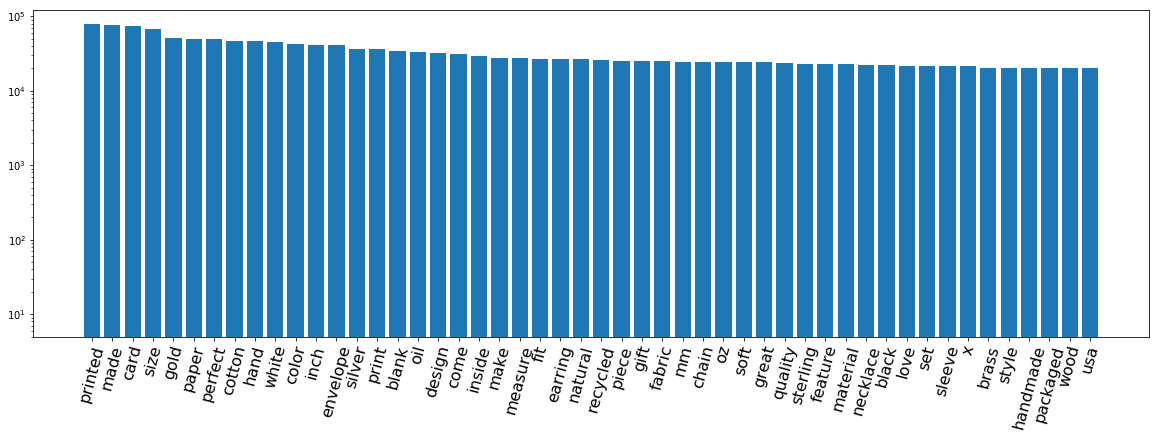

In [29]:
fig, ax = plt.subplots(figsize=(20,6))

plot = plt.bar(x=words_to_plot.keys(), height=words_to_plot.values())

plt.xticks(fontsize=16, rotation=75);
plt.yscale('log')
plt.ylim(5, 120000)

## Finally, slim only to most frequent words above

In [30]:
df_gb['product_description_catalog'] = df_gb['product_description_catalog'].apply(
    lambda x: ' '.join([w for w in str(x).split() if w in frequent_words.keys()]) )

### Train the Doc2Vec model:

In [31]:
tagged_data = [TaggedDocument(words=word_tokenize(str(_d).lower()), tags=[str(i)]) 
               for i, _d in enumerate(df_gb['product_description_catalog'].tolist())]

In [32]:
if retraindoc2vec:
    print('Going to train doc2vec')
    model = Doc2Vec(size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=min_word_count,
                    dm =0)

    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save("d2v.model")
    print("Model Trained and Saved")

/Users/pedrosalesdebruin/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
2019-02-08 10:27:45,932 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-02-08 10:27:45,932 : INFO : collecting all words and their counts
2019-02-08 10:27:45,933 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags


Going to train doc2vec


2019-02-08 10:27:47,042 : INFO : collected 1468 word types and 4755 unique tags from a corpus of 4755 examples and 6716736 words
2019-02-08 10:27:47,042 : INFO : Loading a fresh vocabulary
2019-02-08 10:27:47,045 : INFO : min_count=1000 retains 1468 unique words (100% of original 1468, drops 0)
2019-02-08 10:27:47,045 : INFO : min_count=1000 leaves 6716736 word corpus (100% of original 6716736, drops 0)
2019-02-08 10:27:47,049 : INFO : deleting the raw counts dictionary of 1468 items
2019-02-08 10:27:47,049 : INFO : sample=0.001 downsamples 58 most-common words
2019-02-08 10:27:47,050 : INFO : downsampling leaves estimated 6127857 word corpus (91.2% of prior 6716736)
2019-02-08 10:27:47,053 : INFO : estimated required memory for 1468 words and 10 dimensions: 1992640 bytes
2019-02-08 10:27:47,053 : INFO : resetting layer weights
/Users/pedrosalesdebruin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `iter` (Attribute will be remove

iteration 0


2019-02-08 10:27:48,130 : INFO : EPOCH 1 - PROGRESS: at 58.80% examples, 3230975 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:27:48,828 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:27:48,831 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:27:48,833 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:27:48,834 : INFO : EPOCH - 1 : training on 6716736 raw words (5502937 effective words) took 1.7s, 3229632 effective words/s
2019-02-08 10:27:49,836 : INFO : EPOCH 2 - PROGRESS: at 59.79% examples, 3284961 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:27:50,499 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:27:50,501 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:27:50,504 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:27:50,504 : INFO : EPOCH - 2 : training on 6716736 raw words (5502043 effe

iteration 1


2019-02-08 10:27:56,491 : INFO : EPOCH 1 - PROGRESS: at 59.45% examples, 3266363 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:27:57,183 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:27:57,185 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:27:57,186 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:27:57,187 : INFO : EPOCH - 1 : training on 6716736 raw words (5501831 effective words) took 1.7s, 3240176 effective words/s
2019-02-08 10:27:58,190 : INFO : EPOCH 2 - PROGRESS: at 59.64% examples, 3277172 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:27:58,850 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:27:58,852 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:27:58,854 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:27:58,855 : INFO : EPOCH - 2 : training on 6716736 raw words (5503857 effe

iteration 2


2019-02-08 10:28:05,175 : INFO : EPOCH 1 - PROGRESS: at 60.50% examples, 3325744 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:05,826 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:05,829 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:05,831 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:05,831 : INFO : EPOCH - 1 : training on 6716736 raw words (5502752 effective words) took 1.7s, 3319065 effective words/s
2019-02-08 10:28:06,836 : INFO : EPOCH 2 - PROGRESS: at 59.64% examples, 3270724 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:07,534 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:07,537 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:07,539 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:07,540 : INFO : EPOCH - 2 : training on 6716736 raw words (5501858 effe

iteration 3


2019-02-08 10:28:13,565 : INFO : EPOCH 1 - PROGRESS: at 58.82% examples, 3239378 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:14,247 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:14,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:14,252 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:14,252 : INFO : EPOCH - 1 : training on 6716736 raw words (5503871 effective words) took 1.7s, 3261223 effective words/s
2019-02-08 10:28:15,257 : INFO : EPOCH 2 - PROGRESS: at 58.82% examples, 3231698 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:15,980 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:15,982 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:15,985 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:15,986 : INFO : EPOCH - 2 : training on 6716736 raw words (5502838 effe

iteration 4


2019-02-08 10:28:22,161 : INFO : EPOCH 1 - PROGRESS: at 58.97% examples, 3247174 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:22,851 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:22,853 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:22,856 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:22,856 : INFO : EPOCH - 1 : training on 6716736 raw words (5504292 effective words) took 1.7s, 3246027 effective words/s
2019-02-08 10:28:23,859 : INFO : EPOCH 2 - PROGRESS: at 58.80% examples, 3228271 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:24,553 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:24,555 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:24,557 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:24,558 : INFO : EPOCH - 2 : training on 6716736 raw words (5502771 effe

iteration 5


2019-02-08 10:28:30,862 : INFO : EPOCH 1 - PROGRESS: at 50.45% examples, 2768113 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:31,845 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:31,847 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:31,850 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:31,851 : INFO : EPOCH - 1 : training on 6716736 raw words (5503651 effective words) took 2.0s, 2766844 effective words/s
2019-02-08 10:28:32,853 : INFO : EPOCH 2 - PROGRESS: at 53.77% examples, 2953675 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:33,716 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:33,717 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:33,719 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:33,719 : INFO : EPOCH - 2 : training on 6716736 raw words (5502447 effe

iteration 6


2019-02-08 10:28:39,977 : INFO : EPOCH 1 - PROGRESS: at 54.97% examples, 3031045 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:40,748 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:40,750 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:40,753 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:40,753 : INFO : EPOCH - 1 : training on 6716736 raw words (5502572 effective words) took 1.8s, 3096613 effective words/s
2019-02-08 10:28:41,758 : INFO : EPOCH 2 - PROGRESS: at 58.53% examples, 3213413 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:42,469 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:42,472 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:42,474 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:42,475 : INFO : EPOCH - 2 : training on 6716736 raw words (5503075 effe

iteration 7


2019-02-08 10:28:48,950 : INFO : EPOCH 1 - PROGRESS: at 52.70% examples, 2889457 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:49,849 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:49,851 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:49,854 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:49,854 : INFO : EPOCH - 1 : training on 6716736 raw words (5502966 effective words) took 1.9s, 2887884 effective words/s
2019-02-08 10:28:50,857 : INFO : EPOCH 2 - PROGRESS: at 52.98% examples, 2910943 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:51,716 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:51,718 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:51,721 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:51,721 : INFO : EPOCH - 2 : training on 6716736 raw words (5503378 effe

iteration 8


2019-02-08 10:28:58,869 : INFO : EPOCH 1 - PROGRESS: at 53.35% examples, 2925143 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:28:59,752 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:28:59,753 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:28:59,754 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:28:59,755 : INFO : EPOCH - 1 : training on 6716736 raw words (5502182 effective words) took 1.9s, 2911237 effective words/s
2019-02-08 10:29:00,758 : INFO : EPOCH 2 - PROGRESS: at 47.42% examples, 2641935 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:01,732 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:01,733 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:01,735 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:01,735 : INFO : EPOCH - 2 : training on 6716736 raw words (5503403 effe

iteration 9


2019-02-08 10:29:08,286 : INFO : EPOCH 1 - PROGRESS: at 54.41% examples, 2977587 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:09,082 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:09,085 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:09,087 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:09,087 : INFO : EPOCH - 1 : training on 6716736 raw words (5502881 effective words) took 1.8s, 3048555 effective words/s
2019-02-08 10:29:10,091 : INFO : EPOCH 2 - PROGRESS: at 54.34% examples, 2985647 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:29:10,892 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:10,894 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:10,897 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:10,897 : INFO : EPOCH - 2 : training on 6716736 raw words (5503749 effe

iteration 10


2019-02-08 10:29:17,039 : INFO : EPOCH 1 - PROGRESS: at 58.80% examples, 3227785 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:29:17,731 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:17,733 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:17,736 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:17,736 : INFO : EPOCH - 1 : training on 6716736 raw words (5503088 effective words) took 1.7s, 3240435 effective words/s
2019-02-08 10:29:18,739 : INFO : EPOCH 2 - PROGRESS: at 58.53% examples, 3214008 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:19,448 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:19,450 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:19,453 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:19,454 : INFO : EPOCH - 2 : training on 6716736 raw words (5502445 effe

iteration 11


2019-02-08 10:29:25,607 : INFO : EPOCH 1 - PROGRESS: at 58.02% examples, 3198294 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:26,328 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:26,330 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:26,333 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:26,333 : INFO : EPOCH - 1 : training on 6716736 raw words (5502943 effective words) took 1.7s, 3186677 effective words/s
2019-02-08 10:29:27,337 : INFO : EPOCH 2 - PROGRESS: at 57.69% examples, 3169738 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:29:28,107 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:28,110 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:28,113 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:28,114 : INFO : EPOCH - 2 : training on 6716736 raw words (5503469 effe

iteration 12


2019-02-08 10:29:34,595 : INFO : EPOCH 1 - PROGRESS: at 53.77% examples, 2954261 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:35,435 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:35,438 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:35,440 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:35,441 : INFO : EPOCH - 1 : training on 6716736 raw words (5502789 effective words) took 1.8s, 2980291 effective words/s
2019-02-08 10:29:36,445 : INFO : EPOCH 2 - PROGRESS: at 46.81% examples, 2591568 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:37,406 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:37,409 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:37,411 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:37,412 : INFO : EPOCH - 2 : training on 6716736 raw words (5503133 effe

iteration 13


2019-02-08 10:29:43,710 : INFO : EPOCH 1 - PROGRESS: at 58.28% examples, 3202605 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:44,424 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:44,427 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:44,429 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:44,430 : INFO : EPOCH - 1 : training on 6716736 raw words (5503592 effective words) took 1.7s, 3198540 effective words/s
2019-02-08 10:29:45,432 : INFO : EPOCH 2 - PROGRESS: at 56.38% examples, 3099015 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:46,222 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:46,225 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:46,227 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:46,228 : INFO : EPOCH - 2 : training on 6716736 raw words (5502904 effe

iteration 14


2019-02-08 10:29:52,705 : INFO : EPOCH 1 - PROGRESS: at 57.60% examples, 3160656 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:53,421 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:53,423 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:53,425 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:53,426 : INFO : EPOCH - 1 : training on 6716736 raw words (5503063 effective words) took 1.7s, 3194106 effective words/s
2019-02-08 10:29:54,428 : INFO : EPOCH 2 - PROGRESS: at 58.53% examples, 3214978 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:29:55,132 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:29:55,134 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:29:55,135 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:29:55,135 : INFO : EPOCH - 2 : training on 6716736 raw words (5502595 effe

iteration 15


2019-02-08 10:30:01,503 : INFO : EPOCH 1 - PROGRESS: at 54.15% examples, 2972375 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:02,310 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:02,313 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:02,315 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:02,316 : INFO : EPOCH - 1 : training on 6716736 raw words (5502737 effective words) took 1.8s, 3031381 effective words/s
2019-02-08 10:30:03,320 : INFO : EPOCH 2 - PROGRESS: at 55.86% examples, 3058485 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:04,106 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:04,107 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:04,109 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:04,109 : INFO : EPOCH - 2 : training on 6716736 raw words (5503932 effe

iteration 16


2019-02-08 10:30:10,543 : INFO : EPOCH 1 - PROGRESS: at 54.15% examples, 2979385 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:11,362 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:11,363 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:11,365 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:11,365 : INFO : EPOCH - 1 : training on 6716736 raw words (5503963 effective words) took 1.8s, 3019184 effective words/s
2019-02-08 10:30:12,370 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3086035 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:13,158 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:13,161 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:13,164 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:13,164 : INFO : EPOCH - 2 : training on 6716736 raw words (5503144 effe

iteration 17


2019-02-08 10:30:19,698 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3072925 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:20,490 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:20,492 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:20,494 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:20,495 : INFO : EPOCH - 1 : training on 6716736 raw words (5502669 effective words) took 1.8s, 3051588 effective words/s
2019-02-08 10:30:21,500 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3079858 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:22,312 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:22,314 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:22,317 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:22,317 : INFO : EPOCH - 2 : training on 6716736 raw words (5502601 effe

iteration 18


2019-02-08 10:30:28,811 : INFO : EPOCH 1 - PROGRESS: at 54.99% examples, 3031582 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:29,615 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:29,618 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:29,621 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:29,621 : INFO : EPOCH - 1 : training on 6716736 raw words (5503845 effective words) took 1.8s, 3035079 effective words/s
2019-02-08 10:30:30,626 : INFO : EPOCH 2 - PROGRESS: at 55.86% examples, 3060506 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:31,429 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:31,432 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:31,435 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:31,435 : INFO : EPOCH - 2 : training on 6716736 raw words (5503009 effe

iteration 19


2019-02-08 10:30:37,916 : INFO : EPOCH 1 - PROGRESS: at 54.97% examples, 3028769 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:38,700 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:38,703 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:38,705 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:38,706 : INFO : EPOCH - 1 : training on 6716736 raw words (5503650 effective words) took 1.8s, 3072661 effective words/s
2019-02-08 10:30:39,711 : INFO : EPOCH 2 - PROGRESS: at 58.82% examples, 3230619 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:40,430 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:40,433 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:40,435 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:40,436 : INFO : EPOCH - 2 : training on 6716736 raw words (5502944 effe

iteration 20


2019-02-08 10:30:46,866 : INFO : EPOCH 1 - PROGRESS: at 55.86% examples, 3059835 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:47,653 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:47,655 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:47,658 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:47,658 : INFO : EPOCH - 1 : training on 6716736 raw words (5503381 effective words) took 1.8s, 3067005 effective words/s
2019-02-08 10:30:48,662 : INFO : EPOCH 2 - PROGRESS: at 55.86% examples, 3059332 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:49,444 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:49,447 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:49,449 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:49,449 : INFO : EPOCH - 2 : training on 6716736 raw words (5502596 effe

iteration 21


2019-02-08 10:30:55,930 : INFO : EPOCH 1 - PROGRESS: at 55.25% examples, 3042892 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:56,727 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:56,729 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:56,731 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:56,732 : INFO : EPOCH - 1 : training on 6716736 raw words (5502519 effective words) took 1.8s, 3051000 effective words/s
2019-02-08 10:30:57,739 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3080264 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:30:58,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:30:58,517 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:30:58,519 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:30:58,519 : INFO : EPOCH - 2 : training on 6716736 raw words (5503042 effe

iteration 22


2019-02-08 10:31:05,268 : INFO : EPOCH 1 - PROGRESS: at 52.89% examples, 2899117 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:06,156 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:06,159 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:06,162 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:06,162 : INFO : EPOCH - 1 : training on 6716736 raw words (5501843 effective words) took 1.9s, 2901438 effective words/s
2019-02-08 10:31:07,165 : INFO : EPOCH 2 - PROGRESS: at 54.62% examples, 3001570 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:07,993 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:07,996 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:07,999 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:07,999 : INFO : EPOCH - 2 : training on 6716736 raw words (5503324 effe

iteration 23


2019-02-08 10:31:14,631 : INFO : EPOCH 1 - PROGRESS: at 51.55% examples, 2826601 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:15,511 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:15,513 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:15,515 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:15,515 : INFO : EPOCH - 1 : training on 6716736 raw words (5503126 effective words) took 1.9s, 2918316 effective words/s
2019-02-08 10:31:16,522 : INFO : EPOCH 2 - PROGRESS: at 57.29% examples, 3137271 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:17,259 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:17,262 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:17,265 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:17,266 : INFO : EPOCH - 2 : training on 6716736 raw words (5503191 effe

iteration 24


2019-02-08 10:31:23,872 : INFO : EPOCH 1 - PROGRESS: at 57.08% examples, 3134024 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:24,691 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:24,694 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:24,697 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:24,698 : INFO : EPOCH - 1 : training on 6716736 raw words (5503195 effective words) took 1.8s, 3012090 effective words/s
2019-02-08 10:31:25,701 : INFO : EPOCH 2 - PROGRESS: at 47.63% examples, 2649556 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:26,704 : INFO : EPOCH 2 - PROGRESS: at 97.90% examples, 2674245 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:31:26,750 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:26,753 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:26,756 : INFO : worker thread finished; awaiting

iteration 25


2019-02-08 10:31:33,590 : INFO : EPOCH 1 - PROGRESS: at 54.13% examples, 2966252 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:34,441 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:34,444 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:34,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:34,447 : INFO : EPOCH - 1 : training on 6716736 raw words (5502755 effective words) took 1.9s, 2961103 effective words/s
2019-02-08 10:31:35,452 : INFO : EPOCH 2 - PROGRESS: at 54.15% examples, 2971911 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:31:36,292 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:36,294 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:36,297 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:36,298 : INFO : EPOCH - 2 : training on 6716736 raw words (5502408 effe

iteration 26


2019-02-08 10:31:42,785 : INFO : EPOCH 1 - PROGRESS: at 54.41% examples, 2976656 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:43,624 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:43,626 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:43,629 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:43,630 : INFO : EPOCH - 1 : training on 6716736 raw words (5502572 effective words) took 1.8s, 2976371 effective words/s
2019-02-08 10:31:44,633 : INFO : EPOCH 2 - PROGRESS: at 54.91% examples, 3015607 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:45,412 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:45,415 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:45,417 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:45,418 : INFO : EPOCH - 2 : training on 6716736 raw words (5502327 effe

iteration 27


2019-02-08 10:31:51,657 : INFO : EPOCH 1 - PROGRESS: at 53.94% examples, 2959555 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:31:52,485 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:52,487 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:52,489 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:52,490 : INFO : EPOCH - 1 : training on 6716736 raw words (5503818 effective words) took 1.8s, 3000993 effective words/s
2019-02-08 10:31:53,496 : INFO : EPOCH 2 - PROGRESS: at 58.02% examples, 3186968 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:31:54,211 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:31:54,213 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:31:54,216 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:31:54,216 : INFO : EPOCH - 2 : training on 6716736 raw words (5503110 effe

iteration 28


2019-02-08 10:32:00,410 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3087436 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:01,203 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:01,204 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:01,205 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:01,206 : INFO : EPOCH - 1 : training on 6716736 raw words (5502854 effective words) took 1.8s, 3061100 effective words/s
2019-02-08 10:32:02,209 : INFO : EPOCH 2 - PROGRESS: at 52.89% examples, 2900919 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:03,022 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:03,024 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:03,026 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:03,026 : INFO : EPOCH - 2 : training on 6716736 raw words (5502307 effe

iteration 29


2019-02-08 10:32:09,431 : INFO : EPOCH 1 - PROGRESS: at 53.54% examples, 2937398 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:10,279 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:10,282 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:10,284 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:10,285 : INFO : EPOCH - 1 : training on 6716736 raw words (5503096 effective words) took 1.9s, 2961802 effective words/s
2019-02-08 10:32:11,289 : INFO : EPOCH 2 - PROGRESS: at 54.91% examples, 3010307 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:12,135 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:12,137 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:12,140 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:12,141 : INFO : EPOCH - 2 : training on 6716736 raw words (5503082 effe

iteration 30


2019-02-08 10:32:18,558 : INFO : EPOCH 1 - PROGRESS: at 54.91% examples, 3009852 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:19,365 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:19,367 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:19,369 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:19,370 : INFO : EPOCH - 1 : training on 6716736 raw words (5503428 effective words) took 1.8s, 3034702 effective words/s
2019-02-08 10:32:20,375 : INFO : EPOCH 2 - PROGRESS: at 55.60% examples, 3056034 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:32:21,131 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:21,133 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:21,135 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:21,136 : INFO : EPOCH - 2 : training on 6716736 raw words (5502826 effe

iteration 31


2019-02-08 10:32:27,441 : INFO : EPOCH 1 - PROGRESS: at 54.97% examples, 3030158 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:28,281 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:28,283 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:28,286 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:28,286 : INFO : EPOCH - 1 : training on 6716736 raw words (5503139 effective words) took 1.8s, 2980841 effective words/s
2019-02-08 10:32:29,289 : INFO : EPOCH 2 - PROGRESS: at 46.81% examples, 2591386 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:30,292 : INFO : EPOCH 2 - PROGRESS: at 93.35% examples, 2547185 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:30,438 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:30,441 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:30,444 : INFO : worker thread finished; awaiting

iteration 32


2019-02-08 10:32:37,169 : INFO : EPOCH 1 - PROGRESS: at 53.94% examples, 2955068 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:38,034 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:38,036 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:38,038 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:38,039 : INFO : EPOCH - 1 : training on 6716736 raw words (5501821 effective words) took 1.9s, 2938099 effective words/s
2019-02-08 10:32:39,042 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3089317 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:39,799 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:39,801 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:39,804 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:39,804 : INFO : EPOCH - 2 : training on 6716736 raw words (5502872 effe

iteration 33


2019-02-08 10:32:46,157 : INFO : EPOCH 1 - PROGRESS: at 57.29% examples, 3134689 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:46,899 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:46,901 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:46,903 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:46,904 : INFO : EPOCH - 1 : training on 6716736 raw words (5502809 effective words) took 1.8s, 3141767 effective words/s
2019-02-08 10:32:47,907 : INFO : EPOCH 2 - PROGRESS: at 57.60% examples, 3160312 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:48,644 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:48,647 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:48,650 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:48,650 : INFO : EPOCH - 2 : training on 6716736 raw words (5502657 effe

iteration 34


2019-02-08 10:32:54,954 : INFO : EPOCH 1 - PROGRESS: at 56.74% examples, 3111046 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:55,763 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:55,765 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:55,768 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:55,769 : INFO : EPOCH - 1 : training on 6716736 raw words (5503843 effective words) took 1.8s, 3027641 effective words/s
2019-02-08 10:32:56,772 : INFO : EPOCH 2 - PROGRESS: at 57.60% examples, 3162098 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:32:57,511 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:32:57,513 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:32:57,514 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:32:57,515 : INFO : EPOCH - 2 : training on 6716736 raw words (5502785 effe

iteration 35


2019-02-08 10:33:03,811 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3069640 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:04,593 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:04,594 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:04,595 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:04,596 : INFO : EPOCH - 1 : training on 6716736 raw words (5502625 effective words) took 1.8s, 3069985 effective words/s
2019-02-08 10:33:05,598 : INFO : EPOCH 2 - PROGRESS: at 56.57% examples, 3107198 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:06,363 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:06,365 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:06,368 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:06,368 : INFO : EPOCH - 2 : training on 6716736 raw words (5502559 effe

iteration 36


2019-02-08 10:33:12,743 : INFO : EPOCH 1 - PROGRESS: at 57.29% examples, 3140168 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:13,517 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:13,520 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:13,523 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:13,523 : INFO : EPOCH - 1 : training on 6716736 raw words (5502957 effective words) took 1.8s, 3086662 effective words/s
2019-02-08 10:33:14,526 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3089213 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:15,292 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:15,294 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:15,296 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:15,297 : INFO : EPOCH - 2 : training on 6716736 raw words (5501728 effe

iteration 37


2019-02-08 10:33:21,583 : INFO : EPOCH 1 - PROGRESS: at 58.02% examples, 3189643 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:22,307 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:22,309 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:22,312 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:22,312 : INFO : EPOCH - 1 : training on 6716736 raw words (5503215 effective words) took 1.7s, 3175856 effective words/s
2019-02-08 10:33:23,315 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3172652 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:24,044 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:24,046 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:24,049 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:24,049 : INFO : EPOCH - 2 : training on 6716736 raw words (5502301 effe

iteration 38


2019-02-08 10:33:30,441 : INFO : EPOCH 1 - PROGRESS: at 56.05% examples, 3079558 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:31,237 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:31,239 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:31,242 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:31,242 : INFO : EPOCH - 1 : training on 6716736 raw words (5502820 effective words) took 1.8s, 3053926 effective words/s
2019-02-08 10:33:32,248 : INFO : EPOCH 2 - PROGRESS: at 53.54% examples, 2937466 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:33,094 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:33,096 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:33,099 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:33,100 : INFO : EPOCH - 2 : training on 6716736 raw words (5502609 effe

iteration 39


2019-02-08 10:33:39,452 : INFO : EPOCH 1 - PROGRESS: at 57.29% examples, 3144471 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:40,201 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:40,203 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:40,206 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:40,206 : INFO : EPOCH - 1 : training on 6716736 raw words (5502709 effective words) took 1.8s, 3134669 effective words/s
2019-02-08 10:33:41,210 : INFO : EPOCH 2 - PROGRESS: at 57.29% examples, 3144017 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:41,960 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:41,962 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:41,965 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:41,966 : INFO : EPOCH - 2 : training on 6716736 raw words (5502190 effe

iteration 40


2019-02-08 10:33:48,479 : INFO : EPOCH 1 - PROGRESS: at 57.79% examples, 3170253 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:49,226 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:49,228 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:49,231 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:49,231 : INFO : EPOCH - 1 : training on 6716736 raw words (5503201 effective words) took 1.8s, 3137421 effective words/s
2019-02-08 10:33:50,236 : INFO : EPOCH 2 - PROGRESS: at 51.13% examples, 2783289 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:51,237 : INFO : EPOCH 2 - PROGRESS: at 95.14% examples, 2592209 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:51,364 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:51,367 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:51,370 : INFO : worker thread finished; awaiting

iteration 41


2019-02-08 10:33:58,088 : INFO : EPOCH 1 - PROGRESS: at 54.60% examples, 2995798 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:33:58,906 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:33:58,908 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:33:58,911 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:33:58,911 : INFO : EPOCH - 1 : training on 6716736 raw words (5502775 effective words) took 1.8s, 3016696 effective words/s
2019-02-08 10:33:59,913 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3174084 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:00,672 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:00,674 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:00,676 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:00,677 : INFO : EPOCH - 2 : training on 6716736 raw words (5502806 effe

iteration 42


2019-02-08 10:34:06,928 : INFO : EPOCH 1 - PROGRESS: at 57.88% examples, 3180506 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:07,653 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:07,655 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:07,658 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:07,658 : INFO : EPOCH - 1 : training on 6716736 raw words (5501936 effective words) took 1.7s, 3178376 effective words/s
2019-02-08 10:34:08,661 : INFO : EPOCH 2 - PROGRESS: at 54.91% examples, 3015143 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:09,447 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:09,450 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:09,452 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:09,453 : INFO : EPOCH - 2 : training on 6716736 raw words (5503098 effe

iteration 43


2019-02-08 10:34:15,710 : INFO : EPOCH 1 - PROGRESS: at 58.28% examples, 3207015 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:16,419 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:16,421 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:16,423 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:16,424 : INFO : EPOCH - 1 : training on 6716736 raw words (5503495 effective words) took 1.7s, 3211584 effective words/s
2019-02-08 10:34:17,426 : INFO : EPOCH 2 - PROGRESS: at 58.15% examples, 3196675 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:18,155 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:18,157 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:18,159 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:18,160 : INFO : EPOCH - 2 : training on 6716736 raw words (5502964 effe

iteration 44


2019-02-08 10:34:24,422 : INFO : EPOCH 1 - PROGRESS: at 58.02% examples, 3186294 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:25,156 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:25,159 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:25,161 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:25,162 : INFO : EPOCH - 1 : training on 6716736 raw words (5502748 effective words) took 1.7s, 3155717 effective words/s
2019-02-08 10:34:26,164 : INFO : EPOCH 2 - PROGRESS: at 56.85% examples, 3125842 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:26,942 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:26,943 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:26,945 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:26,945 : INFO : EPOCH - 2 : training on 6716736 raw words (5503897 effe

iteration 45


2019-02-08 10:34:33,240 : INFO : EPOCH 1 - PROGRESS: at 53.96% examples, 2963841 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:34,056 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:34,058 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:34,061 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:34,061 : INFO : EPOCH - 1 : training on 6716736 raw words (5503340 effective words) took 1.8s, 3021019 effective words/s
2019-02-08 10:34:35,065 : INFO : EPOCH 2 - PROGRESS: at 57.08% examples, 3131810 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:35,830 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:35,831 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:35,833 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:35,833 : INFO : EPOCH - 2 : training on 6716736 raw words (5503594 effe

iteration 46


2019-02-08 10:34:42,254 : INFO : EPOCH 1 - PROGRESS: at 58.02% examples, 3191003 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:42,969 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:42,971 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:42,973 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:42,974 : INFO : EPOCH - 1 : training on 6716736 raw words (5502745 effective words) took 1.7s, 3193710 effective words/s
2019-02-08 10:34:43,978 : INFO : EPOCH 2 - PROGRESS: at 58.15% examples, 3190544 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:44,734 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:44,736 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:44,739 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:44,739 : INFO : EPOCH - 2 : training on 6716736 raw words (5503351 effe

iteration 47


2019-02-08 10:34:50,980 : INFO : EPOCH 1 - PROGRESS: at 57.08% examples, 3133700 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:51,705 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:51,707 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:51,709 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:51,710 : INFO : EPOCH - 1 : training on 6716736 raw words (5502912 effective words) took 1.7s, 3179654 effective words/s
2019-02-08 10:34:52,714 : INFO : EPOCH 2 - PROGRESS: at 58.82% examples, 3232868 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:34:53,417 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:34:53,418 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:34:53,419 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:34:53,420 : INFO : EPOCH - 2 : training on 6716736 raw words (5502669 effe

iteration 48


2019-02-08 10:34:59,679 : INFO : EPOCH 1 - PROGRESS: at 58.02% examples, 3182671 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:00,396 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:00,398 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:00,399 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:00,400 : INFO : EPOCH - 1 : training on 6716736 raw words (5503420 effective words) took 1.7s, 3188884 effective words/s
2019-02-08 10:35:01,403 : INFO : EPOCH 2 - PROGRESS: at 57.88% examples, 3179622 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:02,137 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:02,140 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:02,142 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:02,143 : INFO : EPOCH - 2 : training on 6716736 raw words (5503341 effe

iteration 49


2019-02-08 10:35:08,371 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3077316 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:09,119 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:09,121 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:09,124 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:09,124 : INFO : EPOCH - 1 : training on 6716736 raw words (5502422 effective words) took 1.8s, 3130155 effective words/s
2019-02-08 10:35:10,127 : INFO : EPOCH 2 - PROGRESS: at 58.28% examples, 3205812 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:10,849 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:10,851 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:10,853 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:10,854 : INFO : EPOCH - 2 : training on 6716736 raw words (5503476 effe

iteration 50


2019-02-08 10:35:17,060 : INFO : EPOCH 1 - PROGRESS: at 57.60% examples, 3162475 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:17,792 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:17,793 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:17,795 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:17,795 : INFO : EPOCH - 1 : training on 6716736 raw words (5503295 effective words) took 1.7s, 3169588 effective words/s
2019-02-08 10:35:18,800 : INFO : EPOCH 2 - PROGRESS: at 57.29% examples, 3140105 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:19,566 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:19,570 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:19,574 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:19,575 : INFO : EPOCH - 2 : training on 6716736 raw words (5502363 effe

iteration 51


2019-02-08 10:35:26,046 : INFO : EPOCH 1 - PROGRESS: at 55.86% examples, 3058094 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:26,822 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:26,825 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:26,828 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:26,828 : INFO : EPOCH - 1 : training on 6716736 raw words (5503185 effective words) took 1.8s, 3082888 effective words/s
2019-02-08 10:35:27,833 : INFO : EPOCH 2 - PROGRESS: at 57.46% examples, 3155620 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:28,559 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:28,560 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:28,562 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:28,562 : INFO : EPOCH - 2 : training on 6716736 raw words (5503136 effe

iteration 52


2019-02-08 10:35:34,843 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3089765 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:35,622 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:35,625 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:35,628 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:35,629 : INFO : EPOCH - 1 : training on 6716736 raw words (5502283 effective words) took 1.8s, 3080086 effective words/s
2019-02-08 10:35:36,634 : INFO : EPOCH 2 - PROGRESS: at 54.41% examples, 2980166 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:37,431 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:37,433 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:37,436 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:37,436 : INFO : EPOCH - 2 : training on 6716736 raw words (5502846 effe

iteration 53


2019-02-08 10:35:43,897 : INFO : EPOCH 1 - PROGRESS: at 55.25% examples, 3047660 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:44,660 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:44,663 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:44,665 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:44,665 : INFO : EPOCH - 1 : training on 6716736 raw words (5503407 effective words) took 1.8s, 3111363 effective words/s
2019-02-08 10:35:45,670 : INFO : EPOCH 2 - PROGRESS: at 58.82% examples, 3232171 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:46,405 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:46,408 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:46,411 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:46,411 : INFO : EPOCH - 2 : training on 6716736 raw words (5503129 effe

iteration 54


2019-02-08 10:35:52,646 : INFO : EPOCH 1 - PROGRESS: at 57.29% examples, 3147462 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:53,377 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:53,380 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:53,382 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:53,382 : INFO : EPOCH - 1 : training on 6716736 raw words (5503186 effective words) took 1.7s, 3167658 effective words/s
2019-02-08 10:35:54,386 : INFO : EPOCH 2 - PROGRESS: at 58.82% examples, 3235556 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:35:55,099 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:35:55,101 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:35:55,103 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:35:55,104 : INFO : EPOCH - 2 : training on 6716736 raw words (5502959 effe

iteration 55


2019-02-08 10:36:01,874 : INFO : EPOCH 1 - PROGRESS: at 46.96% examples, 2606960 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:36:02,879 : INFO : EPOCH 1 - PROGRESS: at 96.97% examples, 2630706 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:02,952 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:02,955 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:02,958 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:02,959 : INFO : EPOCH - 1 : training on 6716736 raw words (5503157 effective words) took 2.1s, 2639911 effective words/s
2019-02-08 10:36:03,966 : INFO : EPOCH 2 - PROGRESS: at 53.54% examples, 2931222 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:04,851 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:04,854 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:04,857 : INFO : worker thread finished; awaiting

iteration 56


2019-02-08 10:36:11,413 : INFO : EPOCH 1 - PROGRESS: at 58.28% examples, 3202487 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:12,179 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:12,181 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:12,183 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:12,184 : INFO : EPOCH - 1 : training on 6716736 raw words (5502492 effective words) took 1.8s, 3104379 effective words/s
2019-02-08 10:36:13,188 : INFO : EPOCH 2 - PROGRESS: at 53.35% examples, 2931885 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:14,060 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:14,063 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:14,066 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:14,066 : INFO : EPOCH - 2 : training on 6716736 raw words (5502686 effe

iteration 57


2019-02-08 10:36:20,923 : INFO : EPOCH 1 - PROGRESS: at 51.97% examples, 2848832 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:21,838 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:21,841 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:21,844 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:21,844 : INFO : EPOCH - 1 : training on 6716736 raw words (5502817 effective words) took 1.9s, 2861830 effective words/s
2019-02-08 10:36:22,849 : INFO : EPOCH 2 - PROGRESS: at 54.41% examples, 2983617 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:36:23,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:23,705 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:23,707 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:23,708 : INFO : EPOCH - 2 : training on 6716736 raw words (5503177 effe

iteration 58


2019-02-08 10:36:30,254 : INFO : EPOCH 1 - PROGRESS: at 54.45% examples, 3001908 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:36:31,102 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:31,104 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:31,107 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:31,108 : INFO : EPOCH - 1 : training on 6716736 raw words (5502816 effective words) took 1.9s, 2968213 effective words/s
2019-02-08 10:36:32,111 : INFO : EPOCH 2 - PROGRESS: at 54.97% examples, 3029370 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:32,919 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:32,920 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:32,923 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:32,923 : INFO : EPOCH - 2 : training on 6716736 raw words (5501966 effe

iteration 59


2019-02-08 10:36:39,421 : INFO : EPOCH 1 - PROGRESS: at 48.18% examples, 2673086 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:40,360 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:40,363 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:40,366 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:40,366 : INFO : EPOCH - 1 : training on 6716736 raw words (5503643 effective words) took 1.9s, 2826960 effective words/s
2019-02-08 10:36:41,371 : INFO : EPOCH 2 - PROGRESS: at 52.16% examples, 2856555 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:42,250 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:42,252 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:42,255 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:42,255 : INFO : EPOCH - 2 : training on 6716736 raw words (5502448 effe

iteration 60


2019-02-08 10:36:48,804 : INFO : EPOCH 1 - PROGRESS: at 55.25% examples, 3048618 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:49,638 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:49,640 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:49,642 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:49,642 : INFO : EPOCH - 1 : training on 6716736 raw words (5503533 effective words) took 1.8s, 2994358 effective words/s
2019-02-08 10:36:50,648 : INFO : EPOCH 2 - PROGRESS: at 53.54% examples, 2937732 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:51,498 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:51,501 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:51,504 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:51,504 : INFO : EPOCH - 2 : training on 6716736 raw words (5503551 effe

iteration 61


2019-02-08 10:36:58,086 : INFO : EPOCH 1 - PROGRESS: at 51.52% examples, 2820534 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:36:59,039 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:36:59,040 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:36:59,042 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:36:59,043 : INFO : EPOCH - 1 : training on 6716736 raw words (5503053 effective words) took 2.0s, 2811701 effective words/s
2019-02-08 10:37:00,046 : INFO : EPOCH 2 - PROGRESS: at 55.86% examples, 3061705 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:00,846 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:00,849 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:00,851 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:00,852 : INFO : EPOCH - 2 : training on 6716736 raw words (5502570 effe

iteration 62


2019-02-08 10:37:07,160 : INFO : EPOCH 1 - PROGRESS: at 55.88% examples, 3071593 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:07,977 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:07,978 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:07,980 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:07,980 : INFO : EPOCH - 1 : training on 6716736 raw words (5503032 effective words) took 1.8s, 3021990 effective words/s
2019-02-08 10:37:08,984 : INFO : EPOCH 2 - PROGRESS: at 56.05% examples, 3079232 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:09,744 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:09,746 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:09,748 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:09,749 : INFO : EPOCH - 2 : training on 6716736 raw words (5503217 effe

iteration 63


2019-02-08 10:37:16,037 : INFO : EPOCH 1 - PROGRESS: at 52.39% examples, 2866818 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:16,867 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:16,868 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:16,870 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:16,871 : INFO : EPOCH - 1 : training on 6716736 raw words (5502562 effective words) took 1.8s, 2993905 effective words/s
2019-02-08 10:37:17,874 : INFO : EPOCH 2 - PROGRESS: at 54.41% examples, 2984906 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:18,677 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:18,679 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:18,682 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:18,682 : INFO : EPOCH - 2 : training on 6716736 raw words (5502924 effe

iteration 64


2019-02-08 10:37:25,180 : INFO : EPOCH 1 - PROGRESS: at 51.50% examples, 2808574 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:26,109 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:26,111 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:26,114 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:26,115 : INFO : EPOCH - 1 : training on 6716736 raw words (5503338 effective words) took 1.9s, 2842938 effective words/s
2019-02-08 10:37:27,119 : INFO : EPOCH 2 - PROGRESS: at 54.15% examples, 2974846 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:27,963 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:27,965 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:27,968 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:27,969 : INFO : EPOCH - 2 : training on 6716736 raw words (5503839 effe

iteration 65


2019-02-08 10:37:34,468 : INFO : EPOCH 1 - PROGRESS: at 54.91% examples, 3002472 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:35,299 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:35,301 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:35,304 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:35,305 : INFO : EPOCH - 1 : training on 6716736 raw words (5504069 effective words) took 1.8s, 2988435 effective words/s
2019-02-08 10:37:36,311 : INFO : EPOCH 2 - PROGRESS: at 54.15% examples, 2969742 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:37,142 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:37,143 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:37,145 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:37,145 : INFO : EPOCH - 2 : training on 6716736 raw words (5502028 effe

iteration 66


2019-02-08 10:37:43,745 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3087642 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:44,491 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:44,493 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:44,494 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:44,495 : INFO : EPOCH - 1 : training on 6716736 raw words (5502753 effective words) took 1.8s, 3142350 effective words/s
2019-02-08 10:37:45,497 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3174810 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:46,214 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:46,215 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:46,217 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:46,217 : INFO : EPOCH - 2 : training on 6716736 raw words (5503343 effe

iteration 67


2019-02-08 10:37:52,572 : INFO : EPOCH 1 - PROGRESS: at 58.02% examples, 3182828 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:53,290 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:53,291 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:53,293 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:53,293 : INFO : EPOCH - 1 : training on 6716736 raw words (5503585 effective words) took 1.7s, 3186740 effective words/s
2019-02-08 10:37:54,296 : INFO : EPOCH 2 - PROGRESS: at 54.99% examples, 3039113 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:37:55,090 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:37:55,092 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:37:55,095 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:37:55,095 : INFO : EPOCH - 2 : training on 6716736 raw words (5502091 effe

iteration 68


2019-02-08 10:38:01,599 : INFO : EPOCH 1 - PROGRESS: at 57.60% examples, 3166564 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:02,328 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:02,329 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:02,331 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:02,331 : INFO : EPOCH - 1 : training on 6716736 raw words (5503590 effective words) took 1.7s, 3176680 effective words/s
2019-02-08 10:38:03,337 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3168240 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:38:04,059 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:04,061 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:04,063 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:04,064 : INFO : EPOCH - 2 : training on 6716736 raw words (5502743 effe

iteration 69


2019-02-08 10:38:10,761 : INFO : EPOCH 1 - PROGRESS: at 57.46% examples, 3155625 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:11,496 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:11,498 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:11,499 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:11,500 : INFO : EPOCH - 1 : training on 6716736 raw words (5503493 effective words) took 1.7s, 3162695 effective words/s
2019-02-08 10:38:12,503 : INFO : EPOCH 2 - PROGRESS: at 55.86% examples, 3059219 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:13,291 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:13,292 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:13,293 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:13,294 : INFO : EPOCH - 2 : training on 6716736 raw words (5502463 effe

iteration 70


2019-02-08 10:38:19,647 : INFO : EPOCH 1 - PROGRESS: at 57.29% examples, 3147236 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:20,384 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:20,385 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:20,386 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:20,387 : INFO : EPOCH - 1 : training on 6716736 raw words (5502809 effective words) took 1.7s, 3161673 effective words/s
2019-02-08 10:38:21,394 : INFO : EPOCH 2 - PROGRESS: at 55.86% examples, 3050508 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:22,238 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:22,241 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:22,243 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:22,244 : INFO : EPOCH - 2 : training on 6716736 raw words (5503024 effe

iteration 71


2019-02-08 10:38:28,698 : INFO : EPOCH 1 - PROGRESS: at 54.24% examples, 2963751 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:29,620 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:29,621 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:29,623 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:29,624 : INFO : EPOCH - 1 : training on 6716736 raw words (5502502 effective words) took 1.9s, 2843274 effective words/s
2019-02-08 10:38:30,626 : INFO : EPOCH 2 - PROGRESS: at 46.08% examples, 2538577 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:31,594 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:31,595 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:31,597 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:31,597 : INFO : EPOCH - 2 : training on 6716736 raw words (5503077 effe

iteration 72


2019-02-08 10:38:37,832 : INFO : EPOCH 1 - PROGRESS: at 52.16% examples, 2854673 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:38,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:38,704 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:38,706 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:38,706 : INFO : EPOCH - 1 : training on 6716736 raw words (5502464 effective words) took 1.9s, 2931792 effective words/s
2019-02-08 10:38:39,708 : INFO : EPOCH 2 - PROGRESS: at 52.20% examples, 2869070 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:40,605 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:40,606 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:40,608 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:40,609 : INFO : EPOCH - 2 : training on 6716736 raw words (5503579 effe

iteration 73


2019-02-08 10:38:47,208 : INFO : EPOCH 1 - PROGRESS: at 54.41% examples, 2971255 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:38:48,090 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:48,092 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:48,098 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:48,099 : INFO : EPOCH - 1 : training on 6716736 raw words (5502233 effective words) took 1.9s, 2900616 effective words/s
2019-02-08 10:38:49,104 : INFO : EPOCH 2 - PROGRESS: at 46.14% examples, 2539338 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:50,106 : INFO : EPOCH 2 - PROGRESS: at 89.80% examples, 2462908 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:50,303 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:50,304 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:50,306 : INFO : worker thread finished; awaiting

iteration 74


2019-02-08 10:38:56,874 : INFO : EPOCH 1 - PROGRESS: at 54.91% examples, 3011308 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:57,651 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:57,652 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:57,653 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:57,654 : INFO : EPOCH - 1 : training on 6716736 raw words (5502786 effective words) took 1.8s, 3088390 effective words/s
2019-02-08 10:38:58,660 : INFO : EPOCH 2 - PROGRESS: at 52.56% examples, 2875572 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:38:59,596 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:38:59,598 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:38:59,601 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:38:59,602 : INFO : EPOCH - 2 : training on 6716736 raw words (5502836 effe

iteration 75


2019-02-08 10:39:05,985 : INFO : EPOCH 1 - PROGRESS: at 58.15% examples, 3178382 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:06,736 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:06,737 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:06,739 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:06,739 : INFO : EPOCH - 1 : training on 6716736 raw words (5502879 effective words) took 1.8s, 3125648 effective words/s
2019-02-08 10:39:07,741 : INFO : EPOCH 2 - PROGRESS: at 53.35% examples, 2938433 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:08,566 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:08,568 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:08,569 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:08,570 : INFO : EPOCH - 2 : training on 6716736 raw words (5503603 effe

iteration 76


2019-02-08 10:39:14,873 : INFO : EPOCH 1 - PROGRESS: at 57.88% examples, 3180968 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:15,605 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:15,608 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:15,611 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:15,611 : INFO : EPOCH - 1 : training on 6716736 raw words (5502148 effective words) took 1.7s, 3164801 effective words/s
2019-02-08 10:39:16,613 : INFO : EPOCH 2 - PROGRESS: at 56.68% examples, 3111682 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:17,363 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:17,365 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:17,367 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:17,368 : INFO : EPOCH - 2 : training on 6716736 raw words (5502548 effe

iteration 77


2019-02-08 10:39:23,751 : INFO : EPOCH 1 - PROGRESS: at 56.74% examples, 3109420 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:24,509 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:24,511 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:24,513 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:24,513 : INFO : EPOCH - 1 : training on 6716736 raw words (5503076 effective words) took 1.8s, 3115527 effective words/s
2019-02-08 10:39:25,515 : INFO : EPOCH 2 - PROGRESS: at 56.38% examples, 3099341 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:26,279 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:26,281 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:26,282 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:26,283 : INFO : EPOCH - 2 : training on 6716736 raw words (5502025 effe

iteration 78


2019-02-08 10:39:32,639 : INFO : EPOCH 1 - PROGRESS: at 57.16% examples, 3140539 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:33,393 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:33,394 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:33,396 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:33,397 : INFO : EPOCH - 1 : training on 6716736 raw words (5502841 effective words) took 1.8s, 3129253 effective words/s
2019-02-08 10:39:34,405 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3071326 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:35,175 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:35,176 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:35,178 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:35,178 : INFO : EPOCH - 2 : training on 6716736 raw words (5500993 effe

iteration 79


2019-02-08 10:39:41,607 : INFO : EPOCH 1 - PROGRESS: at 57.29% examples, 3149410 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:42,346 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:42,349 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:42,351 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:42,352 : INFO : EPOCH - 1 : training on 6716736 raw words (5503014 effective words) took 1.7s, 3153726 effective words/s
2019-02-08 10:39:43,358 : INFO : EPOCH 2 - PROGRESS: at 55.86% examples, 3052248 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:44,114 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:44,114 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:44,116 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:44,117 : INFO : EPOCH - 2 : training on 6716736 raw words (5503811 effe

iteration 80


2019-02-08 10:39:50,524 : INFO : EPOCH 1 - PROGRESS: at 57.16% examples, 3138911 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:51,275 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:51,277 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:51,279 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:51,279 : INFO : EPOCH - 1 : training on 6716736 raw words (5501919 effective words) took 1.8s, 3131903 effective words/s
2019-02-08 10:39:52,285 : INFO : EPOCH 2 - PROGRESS: at 57.46% examples, 3152868 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:39:53,021 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:39:53,023 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:39:53,026 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:39:53,027 : INFO : EPOCH - 2 : training on 6716736 raw words (5503890 effe

iteration 81


2019-02-08 10:39:59,333 : INFO : EPOCH 1 - PROGRESS: at 56.40% examples, 3088869 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:00,090 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:00,091 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:00,093 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:00,093 : INFO : EPOCH - 1 : training on 6716736 raw words (5502778 effective words) took 1.8s, 3120878 effective words/s
2019-02-08 10:40:01,099 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3079669 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:01,854 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:01,858 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:01,861 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:01,862 : INFO : EPOCH - 2 : training on 6716736 raw words (5501731 effe

iteration 82


2019-02-08 10:40:08,296 : INFO : EPOCH 1 - PROGRESS: at 56.40% examples, 3098575 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:09,113 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:09,115 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:09,117 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:09,118 : INFO : EPOCH - 1 : training on 6716736 raw words (5502746 effective words) took 1.8s, 3020617 effective words/s
2019-02-08 10:40:10,122 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3168889 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:10,851 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:10,852 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:10,853 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:10,853 : INFO : EPOCH - 2 : training on 6716736 raw words (5502679 effe

iteration 83


2019-02-08 10:40:17,086 : INFO : EPOCH 1 - PROGRESS: at 58.02% examples, 3182244 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:17,808 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:17,809 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:17,810 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:17,811 : INFO : EPOCH - 1 : training on 6716736 raw words (5503198 effective words) took 1.7s, 3179773 effective words/s
2019-02-08 10:40:18,813 : INFO : EPOCH 2 - PROGRESS: at 56.38% examples, 3099408 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:19,575 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:19,576 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:19,578 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:19,578 : INFO : EPOCH - 2 : training on 6716736 raw words (5502829 effe

iteration 84


2019-02-08 10:40:25,933 : INFO : EPOCH 1 - PROGRESS: at 56.38% examples, 3094645 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:26,694 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:26,695 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:26,696 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:26,697 : INFO : EPOCH - 1 : training on 6716736 raw words (5502797 effective words) took 1.8s, 3116507 effective words/s
2019-02-08 10:40:27,699 : INFO : EPOCH 2 - PROGRESS: at 55.58% examples, 3055706 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:28,487 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:28,489 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:28,491 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:28,492 : INFO : EPOCH - 2 : training on 6716736 raw words (5502833 effe

iteration 85


2019-02-08 10:40:34,872 : INFO : EPOCH 1 - PROGRESS: at 56.68% examples, 3110086 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:35,638 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:35,640 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:35,643 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:35,643 : INFO : EPOCH - 1 : training on 6716736 raw words (5502903 effective words) took 1.8s, 3106075 effective words/s
2019-02-08 10:40:36,649 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3078639 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:37,426 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:37,428 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:37,430 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:37,431 : INFO : EPOCH - 2 : training on 6716736 raw words (5504053 effe

iteration 86


2019-02-08 10:40:43,829 : INFO : EPOCH 1 - PROGRESS: at 54.91% examples, 3013448 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:44,634 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:44,636 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:44,638 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:44,639 : INFO : EPOCH - 1 : training on 6716736 raw words (5502336 effective words) took 1.8s, 3038865 effective words/s
2019-02-08 10:40:45,644 : INFO : EPOCH 2 - PROGRESS: at 57.46% examples, 3151348 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:46,370 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:46,371 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:46,373 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:46,373 : INFO : EPOCH - 2 : training on 6716736 raw words (5502540 effe

iteration 87


2019-02-08 10:40:52,601 : INFO : EPOCH 1 - PROGRESS: at 57.46% examples, 3158591 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:53,334 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:53,335 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:53,337 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:53,337 : INFO : EPOCH - 1 : training on 6716736 raw words (5503251 effective words) took 1.7s, 3169123 effective words/s
2019-02-08 10:40:54,341 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3170401 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:40:55,174 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:40:55,175 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:40:55,176 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:40:55,178 : INFO : EPOCH - 2 : training on 6716736 raw words (5503785 effe

iteration 88


2019-02-08 10:41:01,768 : INFO : EPOCH 1 - PROGRESS: at 49.13% examples, 2704867 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:41:02,687 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:02,689 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:02,690 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:02,691 : INFO : EPOCH - 1 : training on 6716736 raw words (5502698 effective words) took 1.9s, 2859548 effective words/s
2019-02-08 10:41:03,696 : INFO : EPOCH 2 - PROGRESS: at 55.86% examples, 3055714 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:04,472 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:04,474 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:04,475 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:04,476 : INFO : EPOCH - 2 : training on 6716736 raw words (5502950 effe

iteration 89


2019-02-08 10:41:10,876 : INFO : EPOCH 1 - PROGRESS: at 51.90% examples, 2845047 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:11,725 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:11,727 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:11,728 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:11,729 : INFO : EPOCH - 1 : training on 6716736 raw words (5502321 effective words) took 1.9s, 2969007 effective words/s
2019-02-08 10:41:12,732 : INFO : EPOCH 2 - PROGRESS: at 54.15% examples, 2979436 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:13,555 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:13,556 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:13,558 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:13,558 : INFO : EPOCH - 2 : training on 6716736 raw words (5503621 effe

iteration 90


2019-02-08 10:41:20,479 : INFO : EPOCH 1 - PROGRESS: at 49.13% examples, 2702658 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:21,483 : INFO : EPOCH 1 - PROGRESS: at 98.25% examples, 2690304 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:21,515 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:21,516 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:21,518 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:21,519 : INFO : EPOCH - 1 : training on 6716736 raw words (5504044 effective words) took 2.0s, 2694871 effective words/s
2019-02-08 10:41:22,524 : INFO : EPOCH 2 - PROGRESS: at 48.50% examples, 2677323 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:23,481 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:23,482 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:23,483 : INFO : worker thread finished; awaiting

iteration 91


2019-02-08 10:41:30,129 : INFO : EPOCH 1 - PROGRESS: at 52.98% examples, 2910523 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:31,040 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:31,042 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:31,045 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:31,046 : INFO : EPOCH - 1 : training on 6716736 raw words (5503589 effective words) took 1.9s, 2868994 effective words/s
2019-02-08 10:41:32,049 : INFO : EPOCH 2 - PROGRESS: at 49.13% examples, 2709283 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:32,922 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:32,924 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:32,926 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:32,926 : INFO : EPOCH - 2 : training on 6716736 raw words (5502439 effe

iteration 92


2019-02-08 10:41:39,293 : INFO : EPOCH 1 - PROGRESS: at 56.57% examples, 3107835 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:41:40,094 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:40,096 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:40,098 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:40,098 : INFO : EPOCH - 1 : training on 6716736 raw words (5502601 effective words) took 1.8s, 3047650 effective words/s
2019-02-08 10:41:41,100 : INFO : EPOCH 2 - PROGRESS: at 56.68% examples, 3112004 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:41,874 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:41,877 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:41,879 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:41,880 : INFO : EPOCH - 2 : training on 6716736 raw words (5502804 effe

iteration 93


2019-02-08 10:41:48,222 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3075799 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:49,005 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:49,006 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:49,008 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:49,008 : INFO : EPOCH - 1 : training on 6716736 raw words (5502524 effective words) took 1.8s, 3072279 effective words/s
2019-02-08 10:41:50,011 : INFO : EPOCH 2 - PROGRESS: at 57.81% examples, 3182346 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:50,743 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:50,745 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:50,746 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:50,747 : INFO : EPOCH - 2 : training on 6716736 raw words (5503429 effe

iteration 94


2019-02-08 10:41:57,147 : INFO : EPOCH 1 - PROGRESS: at 53.33% examples, 2921788 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:41:58,053 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:58,054 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:58,056 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:58,056 : INFO : EPOCH - 1 : training on 6716736 raw words (5502662 effective words) took 1.9s, 2878710 effective words/s
2019-02-08 10:41:59,059 : INFO : EPOCH 2 - PROGRESS: at 54.41% examples, 2985451 words/s, in_qsize 6, out_qsize 1
2019-02-08 10:41:59,859 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:41:59,861 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:41:59,864 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:41:59,865 : INFO : EPOCH - 2 : training on 6716736 raw words (5501343 effe

iteration 95


2019-02-08 10:42:06,273 : INFO : EPOCH 1 - PROGRESS: at 53.35% examples, 2924606 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:07,154 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:07,156 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:07,157 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:07,158 : INFO : EPOCH - 1 : training on 6716736 raw words (5502825 effective words) took 1.9s, 2912277 effective words/s
2019-02-08 10:42:08,162 : INFO : EPOCH 2 - PROGRESS: at 52.98% examples, 2908985 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:09,041 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:09,043 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:09,044 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:09,045 : INFO : EPOCH - 2 : training on 6716736 raw words (5503488 effe

iteration 96


2019-02-08 10:42:15,356 : INFO : EPOCH 1 - PROGRESS: at 57.60% examples, 3163269 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:16,087 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:16,089 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:16,090 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:16,091 : INFO : EPOCH - 1 : training on 6716736 raw words (5502516 effective words) took 1.7s, 3170904 effective words/s
2019-02-08 10:42:17,095 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3168985 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:17,823 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:17,825 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:17,828 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:17,828 : INFO : EPOCH - 2 : training on 6716736 raw words (5503274 effe

iteration 97


2019-02-08 10:42:24,360 : INFO : EPOCH 1 - PROGRESS: at 53.94% examples, 2959484 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:25,230 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:25,232 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:25,234 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:25,234 : INFO : EPOCH - 1 : training on 6716736 raw words (5502968 effective words) took 1.9s, 2934815 effective words/s
2019-02-08 10:42:26,236 : INFO : EPOCH 2 - PROGRESS: at 52.39% examples, 2877718 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:27,137 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:27,140 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:27,141 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:27,141 : INFO : EPOCH - 2 : training on 6716736 raw words (5503456 effe

iteration 98


2019-02-08 10:42:33,681 : INFO : EPOCH 1 - PROGRESS: at 49.97% examples, 2732928 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:34,604 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:34,606 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:34,608 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:34,608 : INFO : EPOCH - 1 : training on 6716736 raw words (5501805 effective words) took 1.9s, 2847931 effective words/s
2019-02-08 10:42:35,618 : INFO : EPOCH 2 - PROGRESS: at 54.34% examples, 2967917 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:36,453 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:36,454 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:36,455 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:36,456 : INFO : EPOCH - 2 : training on 6716736 raw words (5502111 effe

iteration 99


2019-02-08 10:42:42,824 : INFO : EPOCH 1 - PROGRESS: at 53.94% examples, 2956974 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:43,726 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:43,727 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:43,728 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:43,729 : INFO : EPOCH - 1 : training on 6716736 raw words (5502297 effective words) took 1.9s, 2885453 effective words/s
2019-02-08 10:42:44,731 : INFO : EPOCH 2 - PROGRESS: at 52.01% examples, 2860484 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:45,605 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:45,607 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:45,609 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:45,609 : INFO : EPOCH - 2 : training on 6716736 raw words (5502567 effe

iteration 100


2019-02-08 10:42:52,058 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3082543 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:42:52,815 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:52,816 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:52,818 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:52,818 : INFO : EPOCH - 1 : training on 6716736 raw words (5502938 effective words) took 1.8s, 3121167 effective words/s
2019-02-08 10:42:53,821 : INFO : EPOCH 2 - PROGRESS: at 57.81% examples, 3183191 words/s, in_qsize 6, out_qsize 1
2019-02-08 10:42:54,582 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:42:54,583 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:42:54,584 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:42:54,585 : INFO : EPOCH - 2 : training on 6716736 raw words (5502823 effe

iteration 101


2019-02-08 10:43:01,120 : INFO : EPOCH 1 - PROGRESS: at 57.29% examples, 3148430 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:01,880 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:01,883 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:01,886 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:01,886 : INFO : EPOCH - 1 : training on 6716736 raw words (5502923 effective words) took 1.8s, 3116024 effective words/s
2019-02-08 10:43:02,889 : INFO : EPOCH 2 - PROGRESS: at 54.15% examples, 2976727 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:03,714 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:03,716 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:03,717 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:03,718 : INFO : EPOCH - 2 : training on 6716736 raw words (5503255 effe

iteration 102


2019-02-08 10:43:10,300 : INFO : EPOCH 1 - PROGRESS: at 57.08% examples, 3134275 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:11,091 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:11,093 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:11,094 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:11,095 : INFO : EPOCH - 1 : training on 6716736 raw words (5501918 effective words) took 1.8s, 3063704 effective words/s
2019-02-08 10:43:12,100 : INFO : EPOCH 2 - PROGRESS: at 54.99% examples, 3032624 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:12,927 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:12,929 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:12,931 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:12,932 : INFO : EPOCH - 2 : training on 6716736 raw words (5503125 effe

iteration 103


2019-02-08 10:43:19,271 : INFO : EPOCH 1 - PROGRESS: at 54.91% examples, 3003859 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:20,065 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:20,068 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:20,071 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:20,071 : INFO : EPOCH - 1 : training on 6716736 raw words (5502410 effective words) took 1.8s, 3048944 effective words/s
2019-02-08 10:43:21,076 : INFO : EPOCH 2 - PROGRESS: at 54.15% examples, 2975257 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:21,879 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:21,880 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:21,882 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:21,882 : INFO : EPOCH - 2 : training on 6716736 raw words (5502339 effe

iteration 104


2019-02-08 10:43:28,579 : INFO : EPOCH 1 - PROGRESS: at 56.40% examples, 3096301 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:29,332 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:29,334 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:29,335 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:29,335 : INFO : EPOCH - 1 : training on 6716736 raw words (5503695 effective words) took 1.8s, 3132863 effective words/s
2019-02-08 10:43:30,339 : INFO : EPOCH 2 - PROGRESS: at 57.46% examples, 3151899 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:31,084 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:31,085 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:31,087 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:31,087 : INFO : EPOCH - 2 : training on 6716736 raw words (5502839 effe

iteration 105


2019-02-08 10:43:37,593 : INFO : EPOCH 1 - PROGRESS: at 54.60% examples, 2998219 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:38,421 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:38,423 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:38,424 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:38,425 : INFO : EPOCH - 1 : training on 6716736 raw words (5502976 effective words) took 1.8s, 3003147 effective words/s
2019-02-08 10:43:39,428 : INFO : EPOCH 2 - PROGRESS: at 52.77% examples, 2896318 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:40,313 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:40,315 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:40,317 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:40,317 : INFO : EPOCH - 2 : training on 6716736 raw words (5503562 effe

iteration 106


2019-02-08 10:43:46,855 : INFO : EPOCH 1 - PROGRESS: at 43.83% examples, 2438996 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:47,858 : INFO : EPOCH 1 - PROGRESS: at 97.58% examples, 2654159 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:47,915 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:47,918 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:47,920 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:47,921 : INFO : EPOCH - 1 : training on 6716736 raw words (5503154 effective words) took 2.1s, 2663210 effective words/s
2019-02-08 10:43:48,924 : INFO : EPOCH 2 - PROGRESS: at 52.83% examples, 2899403 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:49,838 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:49,840 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:49,842 : INFO : worker thread finished; awaiting

iteration 107


2019-02-08 10:43:56,578 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3075699 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:57,366 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:57,368 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:57,369 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:57,370 : INFO : EPOCH - 1 : training on 6716736 raw words (5502798 effective words) took 1.8s, 3062106 effective words/s
2019-02-08 10:43:58,372 : INFO : EPOCH 2 - PROGRESS: at 57.16% examples, 3141061 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:43:59,110 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:43:59,111 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:43:59,113 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:43:59,113 : INFO : EPOCH - 2 : training on 6716736 raw words (5502775 effe

iteration 108


2019-02-08 10:44:05,543 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3082272 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:06,328 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:06,330 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:06,331 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:06,332 : INFO : EPOCH - 1 : training on 6716736 raw words (5501775 effective words) took 1.8s, 3071631 effective words/s
2019-02-08 10:44:07,336 : INFO : EPOCH 2 - PROGRESS: at 53.77% examples, 2949730 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:08,183 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:08,185 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:08,186 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:08,187 : INFO : EPOCH - 2 : training on 6716736 raw words (5503287 effe

iteration 109


2019-02-08 10:44:14,743 : INFO : EPOCH 1 - PROGRESS: at 54.70% examples, 3011112 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:15,563 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:15,564 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:15,565 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:15,565 : INFO : EPOCH - 1 : training on 6716736 raw words (5502787 effective words) took 1.8s, 3019409 effective words/s
2019-02-08 10:44:16,569 : INFO : EPOCH 2 - PROGRESS: at 59.20% examples, 3252868 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:17,247 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:17,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:17,250 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:17,250 : INFO : EPOCH - 2 : training on 6716736 raw words (5502740 effe

iteration 110


2019-02-08 10:44:23,434 : INFO : EPOCH 1 - PROGRESS: at 55.86% examples, 3058340 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:24,204 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:24,206 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:24,207 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:24,207 : INFO : EPOCH - 1 : training on 6716736 raw words (5503353 effective words) took 1.8s, 3099787 effective words/s
2019-02-08 10:44:25,211 : INFO : EPOCH 2 - PROGRESS: at 56.38% examples, 3095186 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:26,003 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:26,005 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:26,006 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:26,007 : INFO : EPOCH - 2 : training on 6716736 raw words (5502504 effe

iteration 111


2019-02-08 10:44:32,648 : INFO : EPOCH 1 - PROGRESS: at 54.15% examples, 2972911 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:33,467 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:33,468 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:33,470 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:33,470 : INFO : EPOCH - 1 : training on 6716736 raw words (5504026 effective words) took 1.8s, 3015762 effective words/s
2019-02-08 10:44:34,474 : INFO : EPOCH 2 - PROGRESS: at 56.40% examples, 3091301 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:44:35,241 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:35,243 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:35,244 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:35,244 : INFO : EPOCH - 2 : training on 6716736 raw words (5502657 effe

iteration 112


2019-02-08 10:44:41,637 : INFO : EPOCH 1 - PROGRESS: at 53.33% examples, 2923238 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:42,467 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:42,469 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:42,470 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:42,471 : INFO : EPOCH - 1 : training on 6716736 raw words (5502724 effective words) took 1.8s, 2998435 effective words/s
2019-02-08 10:44:43,474 : INFO : EPOCH 2 - PROGRESS: at 51.08% examples, 2782802 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:44,427 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:44,429 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:44,430 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:44,430 : INFO : EPOCH - 2 : training on 6716736 raw words (5502793 effe

iteration 113


2019-02-08 10:44:50,913 : INFO : EPOCH 1 - PROGRESS: at 53.54% examples, 2940809 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:51,731 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:51,733 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:51,733 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:51,734 : INFO : EPOCH - 1 : training on 6716736 raw words (5502815 effective words) took 1.8s, 3019265 effective words/s
2019-02-08 10:44:52,736 : INFO : EPOCH 2 - PROGRESS: at 56.21% examples, 3091228 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:44:53,494 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:44:53,495 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:44:53,496 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:44:53,496 : INFO : EPOCH - 2 : training on 6716736 raw words (5503455 effe

iteration 114


2019-02-08 10:44:59,812 : INFO : EPOCH 1 - PROGRESS: at 56.85% examples, 3127943 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:00,566 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:00,569 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:00,570 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:00,570 : INFO : EPOCH - 1 : training on 6716736 raw words (5503173 effective words) took 1.8s, 3129248 effective words/s
2019-02-08 10:45:01,573 : INFO : EPOCH 2 - PROGRESS: at 57.29% examples, 3146446 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:02,312 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:02,315 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:02,317 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:02,317 : INFO : EPOCH - 2 : training on 6716736 raw words (5503258 effe

iteration 115


2019-02-08 10:45:08,605 : INFO : EPOCH 1 - PROGRESS: at 57.79% examples, 3174157 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:09,333 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:09,335 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:09,336 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:09,336 : INFO : EPOCH - 1 : training on 6716736 raw words (5503275 effective words) took 1.7s, 3177522 effective words/s
2019-02-08 10:45:10,340 : INFO : EPOCH 2 - PROGRESS: at 54.91% examples, 3010680 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:11,124 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:11,128 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:11,130 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:11,130 : INFO : EPOCH - 2 : training on 6716736 raw words (5502577 effe

iteration 116


2019-02-08 10:45:17,623 : INFO : EPOCH 1 - PROGRESS: at 55.58% examples, 3055263 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:18,419 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:18,422 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:18,422 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:18,423 : INFO : EPOCH - 1 : training on 6716736 raw words (5503326 effective words) took 1.8s, 3056557 effective words/s
2019-02-08 10:45:19,428 : INFO : EPOCH 2 - PROGRESS: at 54.91% examples, 3006169 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:20,263 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:20,265 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:20,266 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:20,267 : INFO : EPOCH - 2 : training on 6716736 raw words (5503566 effe

iteration 117


2019-02-08 10:45:26,655 : INFO : EPOCH 1 - PROGRESS: at 58.02% examples, 3181968 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:27,376 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:27,378 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:27,379 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:27,380 : INFO : EPOCH - 1 : training on 6716736 raw words (5502971 effective words) took 1.7s, 3181025 effective words/s
2019-02-08 10:45:28,384 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3166139 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:29,108 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:29,110 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:29,111 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:29,111 : INFO : EPOCH - 2 : training on 6716736 raw words (5503001 effe

iteration 118


2019-02-08 10:45:35,423 : INFO : EPOCH 1 - PROGRESS: at 51.97% examples, 2846771 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:36,252 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:36,254 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:36,256 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:36,256 : INFO : EPOCH - 1 : training on 6716736 raw words (5502866 effective words) took 1.8s, 2997063 effective words/s
2019-02-08 10:45:37,260 : INFO : EPOCH 2 - PROGRESS: at 57.60% examples, 3162262 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:38,064 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:38,066 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:38,067 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:38,067 : INFO : EPOCH - 2 : training on 6716736 raw words (5501972 effe

iteration 119


2019-02-08 10:45:44,470 : INFO : EPOCH 1 - PROGRESS: at 56.40% examples, 3097417 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:45,220 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:45,222 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:45,223 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:45,223 : INFO : EPOCH - 1 : training on 6716736 raw words (5503059 effective words) took 1.8s, 3137296 effective words/s
2019-02-08 10:45:46,226 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3174398 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:46,956 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:46,959 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:46,961 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:46,962 : INFO : EPOCH - 2 : training on 6716736 raw words (5502817 effe

iteration 120


2019-02-08 10:45:53,238 : INFO : EPOCH 1 - PROGRESS: at 52.56% examples, 2881606 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:45:54,152 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:54,155 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:54,155 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:54,156 : INFO : EPOCH - 1 : training on 6716736 raw words (5502701 effective words) took 1.9s, 2866857 effective words/s
2019-02-08 10:45:55,158 : INFO : EPOCH 2 - PROGRESS: at 54.99% examples, 3040024 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:45:56,000 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:45:56,002 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:45:56,003 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:45:56,004 : INFO : EPOCH - 2 : training on 6716736 raw words (5502996 effe

iteration 121


2019-02-08 10:46:02,573 : INFO : EPOCH 1 - PROGRESS: at 56.21% examples, 3082177 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:03,336 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:03,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:03,339 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:03,340 : INFO : EPOCH - 1 : training on 6716736 raw words (5503348 effective words) took 1.8s, 3109111 effective words/s
2019-02-08 10:46:04,344 : INFO : EPOCH 2 - PROGRESS: at 57.29% examples, 3142267 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:05,075 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:05,076 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:05,077 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:05,078 : INFO : EPOCH - 2 : training on 6716736 raw words (5502714 effe

iteration 122


2019-02-08 10:46:11,471 : INFO : EPOCH 1 - PROGRESS: at 57.29% examples, 3144175 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:12,182 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:12,184 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:12,185 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:12,185 : INFO : EPOCH - 1 : training on 6716736 raw words (5503266 effective words) took 1.7s, 3206057 effective words/s
2019-02-08 10:46:13,189 : INFO : EPOCH 2 - PROGRESS: at 52.98% examples, 2907714 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:14,189 : INFO : EPOCH 2 - PROGRESS: at 99.35% examples, 2724966 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:14,201 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:14,204 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:14,209 : INFO : worker thread finished; awaiting

iteration 123


2019-02-08 10:46:21,266 : INFO : EPOCH 1 - PROGRESS: at 53.35% examples, 2932852 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:22,134 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:22,136 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:22,138 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:22,138 : INFO : EPOCH - 1 : training on 6716736 raw words (5502901 effective words) took 1.9s, 2937459 effective words/s
2019-02-08 10:46:23,143 : INFO : EPOCH 2 - PROGRESS: at 56.40% examples, 3093085 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:23,998 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:24,000 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:24,001 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:24,002 : INFO : EPOCH - 2 : training on 6716736 raw words (5502452 effe

iteration 124


2019-02-08 10:46:30,506 : INFO : EPOCH 1 - PROGRESS: at 58.82% examples, 3227016 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:31,208 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:31,210 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:31,211 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:31,212 : INFO : EPOCH - 1 : training on 6716736 raw words (5503197 effective words) took 1.7s, 3217628 effective words/s
2019-02-08 10:46:32,215 : INFO : EPOCH 2 - PROGRESS: at 51.08% examples, 2779908 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:33,100 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:33,102 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:33,103 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:33,103 : INFO : EPOCH - 2 : training on 6716736 raw words (5501412 effe

iteration 125


2019-02-08 10:46:39,733 : INFO : EPOCH 1 - PROGRESS: at 56.40% examples, 3092419 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:46:40,555 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:40,558 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:40,559 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:40,560 : INFO : EPOCH - 1 : training on 6716736 raw words (5502843 effective words) took 1.8s, 3008379 effective words/s
2019-02-08 10:46:41,563 : INFO : EPOCH 2 - PROGRESS: at 54.15% examples, 2978579 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:42,437 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:42,439 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:42,440 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:42,441 : INFO : EPOCH - 2 : training on 6716736 raw words (5503868 effe

iteration 126


2019-02-08 10:46:48,923 : INFO : EPOCH 1 - PROGRESS: at 53.77% examples, 2943447 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:49,656 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:49,658 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:49,659 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:49,659 : INFO : EPOCH - 1 : training on 6716736 raw words (5502808 effective words) took 1.7s, 3162393 effective words/s
2019-02-08 10:46:50,663 : INFO : EPOCH 2 - PROGRESS: at 62.52% examples, 3461356 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:51,120 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:51,122 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:51,122 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:51,122 : INFO : EPOCH - 2 : training on 6716736 raw words (5503230 effe

iteration 127


2019-02-08 10:46:56,014 : INFO : EPOCH 1 - PROGRESS: at 78.91% examples, 4313859 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:56,281 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:56,282 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:56,284 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:56,284 : INFO : EPOCH - 1 : training on 6716736 raw words (5502833 effective words) took 1.3s, 4330326 effective words/s
2019-02-08 10:46:57,288 : INFO : EPOCH 2 - PROGRESS: at 79.45% examples, 4359658 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:46:57,537 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:46:57,538 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:46:57,539 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:46:57,540 : INFO : EPOCH - 2 : training on 6716736 raw words (5502646 effe

iteration 128


2019-02-08 10:47:02,192 : INFO : EPOCH 1 - PROGRESS: at 79.50% examples, 4370955 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:02,441 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:02,443 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:02,444 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:02,444 : INFO : EPOCH - 1 : training on 6716736 raw words (5502696 effective words) took 1.3s, 4394172 effective words/s
2019-02-08 10:47:03,447 : INFO : EPOCH 2 - PROGRESS: at 80.97% examples, 4441600 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:03,681 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:03,682 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:03,683 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:03,684 : INFO : EPOCH - 2 : training on 6716736 raw words (5502658 effe

iteration 129


2019-02-08 10:47:08,417 : INFO : EPOCH 1 - PROGRESS: at 82.04% examples, 4498900 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:08,635 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:08,637 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:08,638 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:08,638 : INFO : EPOCH - 1 : training on 6716736 raw words (5502377 effective words) took 1.2s, 4506695 effective words/s
2019-02-08 10:47:09,643 : INFO : EPOCH 2 - PROGRESS: at 83.07% examples, 4547620 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:09,845 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:09,846 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:09,847 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:09,848 : INFO : EPOCH - 2 : training on 6716736 raw words (5502720 effe

iteration 130


2019-02-08 10:47:14,495 : INFO : EPOCH 1 - PROGRESS: at 80.97% examples, 4431091 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:14,724 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:14,725 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:14,726 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:14,727 : INFO : EPOCH - 1 : training on 6716736 raw words (5501954 effective words) took 1.2s, 4455005 effective words/s
2019-02-08 10:47:15,729 : INFO : EPOCH 2 - PROGRESS: at 81.14% examples, 4453973 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:15,959 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:15,960 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:15,961 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:15,961 : INFO : EPOCH - 2 : training on 6716736 raw words (5503234 effe

iteration 131


2019-02-08 10:47:20,657 : INFO : EPOCH 1 - PROGRESS: at 83.07% examples, 4554662 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:20,861 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:20,862 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:20,863 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:20,864 : INFO : EPOCH - 1 : training on 6716736 raw words (5502728 effective words) took 1.2s, 4553563 effective words/s
2019-02-08 10:47:21,869 : INFO : EPOCH 2 - PROGRESS: at 82.38% examples, 4505522 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:22,083 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:22,084 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:22,085 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:22,085 : INFO : EPOCH - 2 : training on 6716736 raw words (5502779 effe

iteration 132


2019-02-08 10:47:26,947 : INFO : EPOCH 1 - PROGRESS: at 72.16% examples, 3947523 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:27,276 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:27,277 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:27,278 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:27,279 : INFO : EPOCH - 1 : training on 6716736 raw words (5503359 effective words) took 1.3s, 4128991 effective words/s
2019-02-08 10:47:28,281 : INFO : EPOCH 2 - PROGRESS: at 86.67% examples, 4754655 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:28,455 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:28,457 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:28,458 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:28,459 : INFO : EPOCH - 2 : training on 6716736 raw words (5502801 effe

iteration 133


2019-02-08 10:47:33,403 : INFO : EPOCH 1 - PROGRESS: at 79.79% examples, 4381971 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:33,649 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:33,651 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:33,652 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:33,652 : INFO : EPOCH - 1 : training on 6716736 raw words (5503429 effective words) took 1.3s, 4402114 effective words/s
2019-02-08 10:47:34,654 : INFO : EPOCH 2 - PROGRESS: at 86.86% examples, 4764060 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:34,804 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:34,806 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:34,807 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:34,807 : INFO : EPOCH - 2 : training on 6716736 raw words (5502795 effe

iteration 134


2019-02-08 10:47:39,424 : INFO : EPOCH 1 - PROGRESS: at 80.42% examples, 4419251 words/s, in_qsize 6, out_qsize 1
2019-02-08 10:47:39,659 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:39,661 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:39,662 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:39,663 : INFO : EPOCH - 1 : training on 6716736 raw words (5502501 effective words) took 1.2s, 4438689 effective words/s
2019-02-08 10:47:40,665 : INFO : EPOCH 2 - PROGRESS: at 79.50% examples, 4370535 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:40,920 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:40,922 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:40,923 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:40,923 : INFO : EPOCH - 2 : training on 6716736 raw words (5502163 effe

iteration 135


2019-02-08 10:47:45,652 : INFO : EPOCH 1 - PROGRESS: at 82.04% examples, 4501143 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:45,871 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:45,872 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:45,872 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:45,873 : INFO : EPOCH - 1 : training on 6716736 raw words (5504104 effective words) took 1.2s, 4507272 effective words/s
2019-02-08 10:47:46,875 : INFO : EPOCH 2 - PROGRESS: at 84.90% examples, 4674257 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:47:47,055 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:47,057 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:47,058 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:47,059 : INFO : EPOCH - 2 : training on 6716736 raw words (5503230 effe

iteration 136


2019-02-08 10:47:51,724 : INFO : EPOCH 1 - PROGRESS: at 82.25% examples, 4502231 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:51,943 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:51,944 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:51,945 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:51,946 : INFO : EPOCH - 1 : training on 6716736 raw words (5504005 effective words) took 1.2s, 4501216 effective words/s
2019-02-08 10:47:52,948 : INFO : EPOCH 2 - PROGRESS: at 82.04% examples, 4498173 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:47:53,165 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:53,166 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:53,167 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:53,168 : INFO : EPOCH - 2 : training on 6716736 raw words (5503063 effe

iteration 137


2019-02-08 10:47:57,848 : INFO : EPOCH 1 - PROGRESS: at 82.02% examples, 4483193 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:47:58,071 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:58,073 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:58,074 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:58,075 : INFO : EPOCH - 1 : training on 6716736 raw words (5503219 effective words) took 1.2s, 4478183 effective words/s
2019-02-08 10:47:59,079 : INFO : EPOCH 2 - PROGRESS: at 79.33% examples, 4345067 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:47:59,343 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:47:59,345 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:47:59,346 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:47:59,346 : INFO : EPOCH - 2 : training on 6716736 raw words (5502867 effe

iteration 138


2019-02-08 10:48:04,325 : INFO : EPOCH 1 - PROGRESS: at 75.90% examples, 4177413 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:48:04,641 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:04,643 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:04,645 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:04,645 : INFO : EPOCH - 1 : training on 6716736 raw words (5503023 effective words) took 1.3s, 4166476 effective words/s
2019-02-08 10:48:05,649 : INFO : EPOCH 2 - PROGRESS: at 75.42% examples, 4145187 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:05,972 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:05,974 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:05,975 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:05,976 : INFO : EPOCH - 2 : training on 6716736 raw words (5503062 effe

iteration 139


2019-02-08 10:48:10,962 : INFO : EPOCH 1 - PROGRESS: at 78.70% examples, 4305801 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:11,245 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:11,247 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:11,248 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:11,249 : INFO : EPOCH - 1 : training on 6716736 raw words (5502511 effective words) took 1.3s, 4274681 effective words/s
2019-02-08 10:48:12,253 : INFO : EPOCH 2 - PROGRESS: at 80.32% examples, 4410514 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:12,501 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:12,502 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:12,503 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:12,503 : INFO : EPOCH - 2 : training on 6716736 raw words (5502979 effe

iteration 140


2019-02-08 10:48:17,427 : INFO : EPOCH 1 - PROGRESS: at 77.46% examples, 4246724 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:17,713 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:17,714 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:17,715 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:17,715 : INFO : EPOCH - 1 : training on 6716736 raw words (5503509 effective words) took 1.3s, 4268806 effective words/s
2019-02-08 10:48:18,719 : INFO : EPOCH 2 - PROGRESS: at 76.34% examples, 4197124 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:19,014 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:19,016 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:19,017 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:19,017 : INFO : EPOCH - 2 : training on 6716736 raw words (5502937 effe

iteration 141


2019-02-08 10:48:23,953 : INFO : EPOCH 1 - PROGRESS: at 73.02% examples, 3994614 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:24,304 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:24,306 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:24,307 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:24,308 : INFO : EPOCH - 1 : training on 6716736 raw words (5502895 effective words) took 1.4s, 4059046 effective words/s
2019-02-08 10:48:25,311 : INFO : EPOCH 2 - PROGRESS: at 76.59% examples, 4208410 words/s, in_qsize 6, out_qsize 1
2019-02-08 10:48:25,604 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:25,605 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:25,607 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:25,607 : INFO : EPOCH - 2 : training on 6716736 raw words (5502308 effe

iteration 142


2019-02-08 10:48:30,465 : INFO : EPOCH 1 - PROGRESS: at 79.28% examples, 4332958 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:30,727 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:30,728 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:30,729 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:30,729 : INFO : EPOCH - 1 : training on 6716736 raw words (5502683 effective words) took 1.3s, 4349271 effective words/s
2019-02-08 10:48:31,732 : INFO : EPOCH 2 - PROGRESS: at 79.31% examples, 4346457 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:32,000 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:32,002 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:32,003 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:32,003 : INFO : EPOCH - 2 : training on 6716736 raw words (5502577 effe

iteration 143


2019-02-08 10:48:36,908 : INFO : EPOCH 1 - PROGRESS: at 79.28% examples, 4334719 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:37,172 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:37,173 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:37,175 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:37,175 : INFO : EPOCH - 1 : training on 6716736 raw words (5502814 effective words) took 1.3s, 4339587 effective words/s
2019-02-08 10:48:38,178 : INFO : EPOCH 2 - PROGRESS: at 78.46% examples, 4288463 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:38,456 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:38,458 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:38,459 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:38,460 : INFO : EPOCH - 2 : training on 6716736 raw words (5502647 effe

iteration 144


2019-02-08 10:48:43,535 : INFO : EPOCH 1 - PROGRESS: at 75.54% examples, 4148477 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:43,860 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:43,862 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:43,864 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:43,864 : INFO : EPOCH - 1 : training on 6716736 raw words (5503269 effective words) took 1.3s, 4132577 effective words/s
2019-02-08 10:48:44,868 : INFO : EPOCH 2 - PROGRESS: at 74.11% examples, 4061980 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:45,221 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:45,223 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:45,225 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:45,225 : INFO : EPOCH - 2 : training on 6716736 raw words (5502739 effe

iteration 145


2019-02-08 10:48:50,278 : INFO : EPOCH 1 - PROGRESS: at 76.95% examples, 4225706 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:50,569 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:50,571 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:50,573 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:50,573 : INFO : EPOCH - 1 : training on 6716736 raw words (5502454 effective words) took 1.3s, 4243259 effective words/s
2019-02-08 10:48:51,577 : INFO : EPOCH 2 - PROGRESS: at 80.02% examples, 4390011 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:51,846 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:51,849 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:51,850 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:51,850 : INFO : EPOCH - 2 : training on 6716736 raw words (5502632 effe

iteration 146


2019-02-08 10:48:56,718 : INFO : EPOCH 1 - PROGRESS: at 79.58% examples, 4367854 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:48:56,968 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:56,970 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:56,971 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:56,972 : INFO : EPOCH - 1 : training on 6716736 raw words (5502576 effective words) took 1.3s, 4386911 effective words/s
2019-02-08 10:48:57,977 : INFO : EPOCH 2 - PROGRESS: at 79.79% examples, 4371533 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:48:58,232 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:48:58,233 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:48:58,234 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:48:58,234 : INFO : EPOCH - 2 : training on 6716736 raw words (5503397 effe

iteration 147


2019-02-08 10:49:03,019 : INFO : EPOCH 1 - PROGRESS: at 79.79% examples, 4373323 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:03,272 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:03,274 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:03,275 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:03,276 : INFO : EPOCH - 1 : training on 6716736 raw words (5503184 effective words) took 1.3s, 4367400 effective words/s
2019-02-08 10:49:04,278 : INFO : EPOCH 2 - PROGRESS: at 79.58% examples, 4369896 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:04,536 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:04,537 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:04,539 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:04,539 : INFO : EPOCH - 2 : training on 6716736 raw words (5502018 effe

iteration 148


2019-02-08 10:49:09,317 : INFO : EPOCH 1 - PROGRESS: at 80.02% examples, 4385190 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:09,563 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:09,565 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:09,566 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:09,566 : INFO : EPOCH - 1 : training on 6716736 raw words (5503493 effective words) took 1.3s, 4394714 effective words/s
2019-02-08 10:49:10,571 : INFO : EPOCH 2 - PROGRESS: at 77.58% examples, 4246259 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:10,853 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:10,855 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:10,856 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:10,857 : INFO : EPOCH - 2 : training on 6716736 raw words (5502714 effe

iteration 149


2019-02-08 10:49:15,634 : INFO : EPOCH 1 - PROGRESS: at 80.42% examples, 4416329 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:15,873 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:15,875 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:15,876 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:15,877 : INFO : EPOCH - 1 : training on 6716736 raw words (5502974 effective words) took 1.2s, 4421230 effective words/s
2019-02-08 10:49:16,879 : INFO : EPOCH 2 - PROGRESS: at 80.42% examples, 4422208 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:17,125 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:17,127 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:17,128 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:17,128 : INFO : EPOCH - 2 : training on 6716736 raw words (5502779 effe

iteration 150


2019-02-08 10:49:21,890 : INFO : EPOCH 1 - PROGRESS: at 79.31% examples, 4343736 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:22,149 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:22,151 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:22,152 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:22,153 : INFO : EPOCH - 1 : training on 6716736 raw words (5502829 effective words) took 1.3s, 4356112 effective words/s
2019-02-08 10:49:23,155 : INFO : EPOCH 2 - PROGRESS: at 79.43% examples, 4353864 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:23,415 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:23,417 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:23,418 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:23,419 : INFO : EPOCH - 2 : training on 6716736 raw words (5503792 effe

iteration 151


2019-02-08 10:49:28,201 : INFO : EPOCH 1 - PROGRESS: at 81.41% examples, 4456442 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:28,433 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:28,435 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:28,436 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:28,437 : INFO : EPOCH - 1 : training on 6716736 raw words (5503045 effective words) took 1.2s, 4449554 effective words/s
2019-02-08 10:49:29,439 : INFO : EPOCH 2 - PROGRESS: at 82.04% examples, 4499168 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:29,662 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:29,664 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:29,666 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:29,666 : INFO : EPOCH - 2 : training on 6716736 raw words (5503511 effe

iteration 152


2019-02-08 10:49:34,413 : INFO : EPOCH 1 - PROGRESS: at 81.56% examples, 4459800 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:34,649 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:34,651 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:34,652 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:34,653 : INFO : EPOCH - 1 : training on 6716736 raw words (5503208 effective words) took 1.2s, 4428144 effective words/s
2019-02-08 10:49:35,656 : INFO : EPOCH 2 - PROGRESS: at 74.22% examples, 4069929 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:36,032 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:36,034 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:36,035 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:36,035 : INFO : EPOCH - 2 : training on 6716736 raw words (5502195 effe

iteration 153


2019-02-08 10:49:40,706 : INFO : EPOCH 1 - PROGRESS: at 79.10% examples, 4325873 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:40,973 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:40,975 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:40,976 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:40,977 : INFO : EPOCH - 1 : training on 6716736 raw words (5503809 effective words) took 1.3s, 4331923 effective words/s
2019-02-08 10:49:41,981 : INFO : EPOCH 2 - PROGRESS: at 78.70% examples, 4304740 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:42,250 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:42,252 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:42,253 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:42,253 : INFO : EPOCH - 2 : training on 6716736 raw words (5502643 effe

iteration 154


2019-02-08 10:49:47,122 : INFO : EPOCH 1 - PROGRESS: at 79.79% examples, 4370436 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:49:47,372 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:47,373 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:47,373 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:47,374 : INFO : EPOCH - 1 : training on 6716736 raw words (5503142 effective words) took 1.3s, 4381898 effective words/s
2019-02-08 10:49:48,378 : INFO : EPOCH 2 - PROGRESS: at 79.79% examples, 4380265 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:48,623 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:48,625 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:48,626 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:48,627 : INFO : EPOCH - 2 : training on 6716736 raw words (5503004 effe

iteration 155


2019-02-08 10:49:53,395 : INFO : EPOCH 1 - PROGRESS: at 80.59% examples, 4427536 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:53,635 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:53,636 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:53,638 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:53,638 : INFO : EPOCH - 1 : training on 6716736 raw words (5502881 effective words) took 1.2s, 4423226 effective words/s
2019-02-08 10:49:54,640 : INFO : EPOCH 2 - PROGRESS: at 81.85% examples, 4483514 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:49:54,867 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:54,868 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:54,870 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:54,871 : INFO : EPOCH - 2 : training on 6716736 raw words (5502824 effe

iteration 156


2019-02-08 10:49:59,630 : INFO : EPOCH 1 - PROGRESS: at 83.70% examples, 4575260 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:49:59,836 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:49:59,837 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:49:59,839 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:49:59,839 : INFO : EPOCH - 1 : training on 6716736 raw words (5502528 effective words) took 1.2s, 4544692 effective words/s
2019-02-08 10:50:00,844 : INFO : EPOCH 2 - PROGRESS: at 80.42% examples, 4410410 words/s, in_qsize 6, out_qsize 1
2019-02-08 10:50:01,080 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:01,081 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:01,083 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:01,084 : INFO : EPOCH - 2 : training on 6716736 raw words (5502961 effe

iteration 157


2019-02-08 10:50:05,818 : INFO : EPOCH 1 - PROGRESS: at 80.97% examples, 4446291 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:06,055 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:06,057 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:06,058 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:06,059 : INFO : EPOCH - 1 : training on 6716736 raw words (5503248 effective words) took 1.2s, 4434195 effective words/s
2019-02-08 10:50:07,061 : INFO : EPOCH 2 - PROGRESS: at 81.14% examples, 4453647 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:07,307 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:07,309 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:07,311 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:07,311 : INFO : EPOCH - 2 : training on 6716736 raw words (5503259 effe

iteration 158


2019-02-08 10:50:12,004 : INFO : EPOCH 1 - PROGRESS: at 81.75% examples, 4474336 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:12,228 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:12,229 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:12,231 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:12,231 : INFO : EPOCH - 1 : training on 6716736 raw words (5502481 effective words) took 1.2s, 4480622 effective words/s
2019-02-08 10:50:13,235 : INFO : EPOCH 2 - PROGRESS: at 80.97% examples, 4439571 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:13,458 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:13,459 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:13,460 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:13,461 : INFO : EPOCH - 2 : training on 6716736 raw words (5503577 effe

iteration 159


2019-02-08 10:50:18,136 : INFO : EPOCH 1 - PROGRESS: at 79.79% examples, 4385437 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:50:18,382 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:18,384 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:18,385 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:18,385 : INFO : EPOCH - 1 : training on 6716736 raw words (5503157 effective words) took 1.2s, 4403640 effective words/s
2019-02-08 10:50:19,389 : INFO : EPOCH 2 - PROGRESS: at 82.02% examples, 4481742 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:19,611 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:19,613 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:19,614 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:19,614 : INFO : EPOCH - 2 : training on 6716736 raw words (5502448 effe

iteration 160


2019-02-08 10:50:24,342 : INFO : EPOCH 1 - PROGRESS: at 82.57% examples, 4526714 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:50:24,551 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:24,553 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:24,554 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:24,555 : INFO : EPOCH - 1 : training on 6716736 raw words (5502563 effective words) took 1.2s, 4536744 effective words/s
2019-02-08 10:50:25,557 : INFO : EPOCH 2 - PROGRESS: at 80.06% examples, 4393103 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:50:25,807 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:25,807 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:25,808 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:25,809 : INFO : EPOCH - 2 : training on 6716736 raw words (5502186 effe

iteration 161


2019-02-08 10:50:30,493 : INFO : EPOCH 1 - PROGRESS: at 81.75% examples, 4473856 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:30,717 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:30,719 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:30,720 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:30,720 : INFO : EPOCH - 1 : training on 6716736 raw words (5503216 effective words) took 1.2s, 4481085 effective words/s
2019-02-08 10:50:31,723 : INFO : EPOCH 2 - PROGRESS: at 81.60% examples, 4464833 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:31,945 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:31,946 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:31,947 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:31,948 : INFO : EPOCH - 2 : training on 6716736 raw words (5502419 effe

iteration 162


2019-02-08 10:50:36,654 : INFO : EPOCH 1 - PROGRESS: at 82.75% examples, 4529452 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:36,859 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:36,860 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:36,861 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:36,861 : INFO : EPOCH - 1 : training on 6716736 raw words (5502988 effective words) took 1.2s, 4551129 effective words/s
2019-02-08 10:50:37,864 : INFO : EPOCH 2 - PROGRESS: at 83.22% examples, 4563018 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:38,070 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:38,071 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:38,072 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:38,073 : INFO : EPOCH - 2 : training on 6716736 raw words (5502741 effe

iteration 163


2019-02-08 10:50:42,729 : INFO : EPOCH 1 - PROGRESS: at 80.42% examples, 4416251 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:42,966 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:42,967 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:42,968 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:42,969 : INFO : EPOCH - 1 : training on 6716736 raw words (5502432 effective words) took 1.2s, 4431309 effective words/s
2019-02-08 10:50:43,971 : INFO : EPOCH 2 - PROGRESS: at 81.14% examples, 4452842 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:44,202 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:44,204 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:44,205 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:44,206 : INFO : EPOCH - 2 : training on 6716736 raw words (5502720 effe

iteration 164


2019-02-08 10:50:48,926 : INFO : EPOCH 1 - PROGRESS: at 76.26% examples, 4190156 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:49,215 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:49,216 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:49,217 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:49,218 : INFO : EPOCH - 1 : training on 6716736 raw words (5503106 effective words) took 1.3s, 4259511 effective words/s
2019-02-08 10:50:50,220 : INFO : EPOCH 2 - PROGRESS: at 79.10% examples, 4326017 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:50,495 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:50,496 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:50,498 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:50,498 : INFO : EPOCH - 2 : training on 6716736 raw words (5503573 effe

iteration 165


2019-02-08 10:50:55,237 : INFO : EPOCH 1 - PROGRESS: at 82.88% examples, 4537379 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:55,446 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:55,447 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:55,448 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:55,449 : INFO : EPOCH - 1 : training on 6716736 raw words (5502069 effective words) took 1.2s, 4540613 effective words/s
2019-02-08 10:50:56,452 : INFO : EPOCH 2 - PROGRESS: at 81.60% examples, 4465800 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:50:56,673 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:50:56,675 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:50:56,676 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:50:56,676 : INFO : EPOCH - 2 : training on 6716736 raw words (5502692 effe

iteration 166


2019-02-08 10:51:01,305 : INFO : EPOCH 1 - PROGRESS: at 85.09% examples, 4678986 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:51:01,488 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:01,490 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:01,491 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:01,492 : INFO : EPOCH - 1 : training on 6716736 raw words (5502647 effective words) took 1.2s, 4630657 effective words/s
2019-02-08 10:51:02,494 : INFO : EPOCH 2 - PROGRESS: at 77.14% examples, 4238712 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:02,799 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:02,800 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:02,801 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:02,802 : INFO : EPOCH - 2 : training on 6716736 raw words (5502870 effe

iteration 167


2019-02-08 10:51:07,506 : INFO : EPOCH 1 - PROGRESS: at 82.02% examples, 4485959 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:07,733 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:07,734 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:07,735 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:07,735 : INFO : EPOCH - 1 : training on 6716736 raw words (5502945 effective words) took 1.2s, 4472755 effective words/s
2019-02-08 10:51:08,739 : INFO : EPOCH 2 - PROGRESS: at 75.54% examples, 4155836 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:09,078 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:09,080 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:09,081 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:09,081 : INFO : EPOCH - 2 : training on 6716736 raw words (5501916 effe

iteration 168


2019-02-08 10:51:14,188 : INFO : EPOCH 1 - PROGRESS: at 74.34% examples, 4092470 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:14,497 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:14,498 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:14,499 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:14,500 : INFO : EPOCH - 1 : training on 6716736 raw words (5503264 effective words) took 1.3s, 4193626 effective words/s
2019-02-08 10:51:15,505 : INFO : EPOCH 2 - PROGRESS: at 73.42% examples, 4017820 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:15,865 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:15,867 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:15,868 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:15,868 : INFO : EPOCH - 2 : training on 6716736 raw words (5502541 effe

iteration 169


2019-02-08 10:51:20,582 : INFO : EPOCH 1 - PROGRESS: at 82.75% examples, 4529294 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:20,792 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:20,793 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:20,794 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:20,795 : INFO : EPOCH - 1 : training on 6716736 raw words (5502586 effective words) took 1.2s, 4529407 effective words/s
2019-02-08 10:51:21,798 : INFO : EPOCH 2 - PROGRESS: at 81.41% examples, 4458992 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:22,021 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:22,022 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:22,023 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:22,024 : INFO : EPOCH - 2 : training on 6716736 raw words (5503156 effe

iteration 170


2019-02-08 10:51:26,715 : INFO : EPOCH 1 - PROGRESS: at 82.38% examples, 4510709 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:26,931 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:26,933 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:26,934 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:26,934 : INFO : EPOCH - 1 : training on 6716736 raw words (5503028 effective words) took 1.2s, 4507166 effective words/s
2019-02-08 10:51:27,938 : INFO : EPOCH 2 - PROGRESS: at 82.02% examples, 4484247 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:28,156 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:28,158 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:28,159 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:28,159 : INFO : EPOCH - 2 : training on 6716736 raw words (5503720 effe

iteration 171


2019-02-08 10:51:32,813 : INFO : EPOCH 1 - PROGRESS: at 81.56% examples, 4464328 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:51:33,037 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:33,038 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:33,039 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:33,040 : INFO : EPOCH - 1 : training on 6716736 raw words (5503464 effective words) took 1.2s, 4478329 effective words/s
2019-02-08 10:51:34,043 : INFO : EPOCH 2 - PROGRESS: at 82.75% examples, 4535771 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:34,248 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:34,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:34,250 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:34,251 : INFO : EPOCH - 2 : training on 6716736 raw words (5502605 effe

iteration 172


2019-02-08 10:51:38,923 : INFO : EPOCH 1 - PROGRESS: at 82.31% examples, 4514103 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:51:39,146 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:39,148 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:39,149 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:39,150 : INFO : EPOCH - 1 : training on 6716736 raw words (5503047 effective words) took 1.2s, 4487934 effective words/s
2019-02-08 10:51:40,152 : INFO : EPOCH 2 - PROGRESS: at 84.31% examples, 4617419 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:40,344 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:40,346 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:40,347 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:40,348 : INFO : EPOCH - 2 : training on 6716736 raw words (5502014 effe

iteration 173


2019-02-08 10:51:44,960 : INFO : EPOCH 1 - PROGRESS: at 81.14% examples, 4450530 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:45,187 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:45,188 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:45,190 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:45,190 : INFO : EPOCH - 1 : training on 6716736 raw words (5502609 effective words) took 1.2s, 4470710 effective words/s
2019-02-08 10:51:46,194 : INFO : EPOCH 2 - PROGRESS: at 82.25% examples, 4500624 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:51:46,409 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:46,410 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:46,411 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:46,412 : INFO : EPOCH - 2 : training on 6716736 raw words (5502133 effe

iteration 174


2019-02-08 10:51:51,080 : INFO : EPOCH 1 - PROGRESS: at 83.07% examples, 4553040 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:51,282 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:51,284 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:51,285 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:51,285 : INFO : EPOCH - 1 : training on 6716736 raw words (5503544 effective words) took 1.2s, 4561207 effective words/s
2019-02-08 10:51:52,287 : INFO : EPOCH 2 - PROGRESS: at 83.70% examples, 4582281 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:52,484 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:52,485 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:52,485 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:52,486 : INFO : EPOCH - 2 : training on 6716736 raw words (5502945 effe

iteration 175


2019-02-08 10:51:57,105 : INFO : EPOCH 1 - PROGRESS: at 82.75% examples, 4532287 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:57,310 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:57,311 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:57,312 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:57,313 : INFO : EPOCH - 1 : training on 6716736 raw words (5502468 effective words) took 1.2s, 4551831 effective words/s
2019-02-08 10:51:58,315 : INFO : EPOCH 2 - PROGRESS: at 82.88% examples, 4538221 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:51:58,521 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:51:58,522 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:51:58,523 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:51:58,524 : INFO : EPOCH - 2 : training on 6716736 raw words (5503491 effe

iteration 176


2019-02-08 10:52:03,180 : INFO : EPOCH 1 - PROGRESS: at 81.41% examples, 4461350 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:03,408 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:03,409 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:03,410 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:03,410 : INFO : EPOCH - 1 : training on 6716736 raw words (5502873 effective words) took 1.2s, 4473659 effective words/s
2019-02-08 10:52:04,413 : INFO : EPOCH 2 - PROGRESS: at 82.02% examples, 4488984 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:04,632 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:04,633 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:04,634 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:04,634 : INFO : EPOCH - 2 : training on 6716736 raw words (5502596 effe

iteration 177


2019-02-08 10:52:09,347 : INFO : EPOCH 1 - PROGRESS: at 82.50% examples, 4515528 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:52:09,560 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:09,562 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:09,562 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:09,563 : INFO : EPOCH - 1 : training on 6716736 raw words (5502733 effective words) took 1.2s, 4519010 effective words/s
2019-02-08 10:52:10,565 : INFO : EPOCH 2 - PROGRESS: at 81.85% examples, 4483074 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:52:10,788 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:10,789 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:10,790 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:10,791 : INFO : EPOCH - 2 : training on 6716736 raw words (5502483 effe

iteration 178


2019-02-08 10:52:15,444 : INFO : EPOCH 1 - PROGRESS: at 81.60% examples, 4464905 words/s, in_qsize 6, out_qsize 1
2019-02-08 10:52:15,666 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:15,668 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:15,669 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:15,670 : INFO : EPOCH - 1 : training on 6716736 raw words (5503164 effective words) took 1.2s, 4487159 effective words/s
2019-02-08 10:52:16,672 : INFO : EPOCH 2 - PROGRESS: at 82.38% examples, 4519648 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:16,883 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:16,884 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:16,885 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:16,886 : INFO : EPOCH - 2 : training on 6716736 raw words (5503728 effe

iteration 179


2019-02-08 10:52:21,544 : INFO : EPOCH 1 - PROGRESS: at 83.79% examples, 4590551 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:21,740 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:21,742 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:21,742 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:21,743 : INFO : EPOCH - 1 : training on 6716736 raw words (5503432 effective words) took 1.2s, 4589629 effective words/s
2019-02-08 10:52:22,745 : INFO : EPOCH 2 - PROGRESS: at 82.50% examples, 4522408 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:52:22,956 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:22,958 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:22,959 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:22,959 : INFO : EPOCH - 2 : training on 6716736 raw words (5504133 effe

iteration 180


2019-02-08 10:52:27,594 : INFO : EPOCH 1 - PROGRESS: at 83.15% examples, 4548903 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:52:27,793 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:27,795 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:27,796 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:27,796 : INFO : EPOCH - 1 : training on 6716736 raw words (5503403 effective words) took 1.2s, 4570052 effective words/s
2019-02-08 10:52:28,799 : INFO : EPOCH 2 - PROGRESS: at 82.02% examples, 4484393 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:29,019 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:29,020 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:29,020 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:29,021 : INFO : EPOCH - 2 : training on 6716736 raw words (5503065 effe

iteration 181


2019-02-08 10:52:33,738 : INFO : EPOCH 1 - PROGRESS: at 79.58% examples, 4365494 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:33,978 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:33,980 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:33,981 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:33,981 : INFO : EPOCH - 1 : training on 6716736 raw words (5502703 effective words) took 1.2s, 4421933 effective words/s
2019-02-08 10:52:34,986 : INFO : EPOCH 2 - PROGRESS: at 80.48% examples, 4411677 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:52:35,217 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:35,219 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:35,220 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:35,221 : INFO : EPOCH - 2 : training on 6716736 raw words (5503444 effe

iteration 182


2019-02-08 10:52:40,126 : INFO : EPOCH 1 - PROGRESS: at 71.50% examples, 3916179 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:40,572 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:40,573 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:40,575 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:40,576 : INFO : EPOCH - 1 : training on 6716736 raw words (5503000 effective words) took 1.5s, 3793756 effective words/s
2019-02-08 10:52:41,579 : INFO : EPOCH 2 - PROGRESS: at 70.20% examples, 3836776 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:42,000 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:42,002 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:42,003 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:42,003 : INFO : EPOCH - 2 : training on 6716736 raw words (5502443 effe

iteration 183


2019-02-08 10:52:47,267 : INFO : EPOCH 1 - PROGRESS: at 73.21% examples, 4010047 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:52:47,624 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:47,626 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:47,627 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:47,628 : INFO : EPOCH - 1 : training on 6716736 raw words (5502652 effective words) took 1.4s, 4038852 effective words/s
2019-02-08 10:52:48,631 : INFO : EPOCH 2 - PROGRESS: at 74.47% examples, 4095009 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:48,955 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:48,957 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:48,958 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:48,959 : INFO : EPOCH - 2 : training on 6716736 raw words (5502679 effe

iteration 184


2019-02-08 10:52:54,077 : INFO : EPOCH 1 - PROGRESS: at 74.74% examples, 4102220 words/s, in_qsize 6, out_qsize 0
2019-02-08 10:52:54,427 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:54,429 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:54,430 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:54,430 : INFO : EPOCH - 1 : training on 6716736 raw words (5502195 effective words) took 1.4s, 4060052 effective words/s
2019-02-08 10:52:55,434 : INFO : EPOCH 2 - PROGRESS: at 74.32% examples, 4080756 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:52:55,764 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:52:55,765 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:52:55,766 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:52:55,767 : INFO : EPOCH - 2 : training on 6716736 raw words (5502484 effe

iteration 185


2019-02-08 10:53:01,059 : INFO : EPOCH 1 - PROGRESS: at 71.50% examples, 3910569 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:01,474 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:01,476 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:01,477 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:01,478 : INFO : EPOCH - 1 : training on 6716736 raw words (5502294 effective words) took 1.4s, 3873810 effective words/s
2019-02-08 10:53:02,480 : INFO : EPOCH 2 - PROGRESS: at 71.52% examples, 3915125 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:02,889 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:02,891 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:02,892 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:02,893 : INFO : EPOCH - 2 : training on 6716736 raw words (5502959 effe

iteration 186


2019-02-08 10:53:08,539 : INFO : EPOCH 1 - PROGRESS: at 64.40% examples, 3529726 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:09,059 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:09,061 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:09,062 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:09,063 : INFO : EPOCH - 1 : training on 6716736 raw words (5503417 effective words) took 1.5s, 3605529 effective words/s
2019-02-08 10:53:10,067 : INFO : EPOCH 2 - PROGRESS: at 69.23% examples, 3777594 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:10,504 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:10,506 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:10,508 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:10,509 : INFO : EPOCH - 2 : training on 6716736 raw words (5503141 effe

iteration 187


2019-02-08 10:53:15,938 : INFO : EPOCH 1 - PROGRESS: at 61.20% examples, 3373118 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:53:16,553 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:16,555 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:16,556 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:16,557 : INFO : EPOCH - 1 : training on 6716736 raw words (5503572 effective words) took 1.6s, 3393298 effective words/s
2019-02-08 10:53:17,560 : INFO : EPOCH 2 - PROGRESS: at 62.15% examples, 3429231 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:53:18,144 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:18,146 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:18,147 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:18,148 : INFO : EPOCH - 2 : training on 6716736 raw words (5502596 effe

iteration 188


2019-02-08 10:53:23,546 : INFO : EPOCH 1 - PROGRESS: at 70.39% examples, 3843274 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:23,951 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:23,953 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:23,954 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:23,954 : INFO : EPOCH - 1 : training on 6716736 raw words (5502732 effective words) took 1.4s, 3903633 effective words/s
2019-02-08 10:53:24,958 : INFO : EPOCH 2 - PROGRESS: at 65.68% examples, 3596331 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:25,505 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:25,507 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:25,508 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:25,509 : INFO : EPOCH - 2 : training on 6716736 raw words (5502872 effe

iteration 189


2019-02-08 10:53:31,031 : INFO : EPOCH 1 - PROGRESS: at 71.92% examples, 3943596 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:31,446 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:31,446 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:31,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:31,448 : INFO : EPOCH - 1 : training on 6716736 raw words (5503175 effective words) took 1.4s, 3883714 effective words/s
2019-02-08 10:53:32,454 : INFO : EPOCH 2 - PROGRESS: at 70.62% examples, 3857938 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:32,875 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:32,876 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:32,877 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:32,878 : INFO : EPOCH - 2 : training on 6716736 raw words (5503441 effe

iteration 190


2019-02-08 10:53:38,106 : INFO : EPOCH 1 - PROGRESS: at 67.57% examples, 3706523 words/s, in_qsize 4, out_qsize 1
2019-02-08 10:53:38,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:38,663 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:38,665 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:38,665 : INFO : EPOCH - 1 : training on 6716736 raw words (5503147 effective words) took 1.6s, 3523197 effective words/s
2019-02-08 10:53:39,670 : INFO : EPOCH 2 - PROGRESS: at 52.77% examples, 2892447 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:40,528 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:40,530 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:40,531 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:40,532 : INFO : EPOCH - 2 : training on 6716736 raw words (5502334 effe

iteration 191


2019-02-08 10:53:46,432 : INFO : EPOCH 1 - PROGRESS: at 61.58% examples, 3393351 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:47,027 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:47,028 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:47,029 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:47,031 : INFO : EPOCH - 1 : training on 6716736 raw words (5502599 effective words) took 1.6s, 3438519 effective words/s
2019-02-08 10:53:48,036 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 3168498 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:48,747 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:48,750 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:48,751 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:48,752 : INFO : EPOCH - 2 : training on 6716736 raw words (5501863 effe

iteration 192


2019-02-08 10:53:54,303 : INFO : EPOCH 1 - PROGRESS: at 73.42% examples, 4028742 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:54,663 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:54,664 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:54,665 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:54,666 : INFO : EPOCH - 1 : training on 6716736 raw words (5503024 effective words) took 1.4s, 4033491 effective words/s
2019-02-08 10:53:55,669 : INFO : EPOCH 2 - PROGRESS: at 73.52% examples, 4037232 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:53:56,027 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:53:56,028 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:53:56,029 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:53:56,030 : INFO : EPOCH - 2 : training on 6716736 raw words (5502239 effe

iteration 193


2019-02-08 10:54:01,200 : INFO : EPOCH 1 - PROGRESS: at 70.20% examples, 3837817 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:01,626 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:01,628 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:01,629 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:01,630 : INFO : EPOCH - 1 : training on 6716736 raw words (5503330 effective words) took 1.4s, 3846987 effective words/s
2019-02-08 10:54:02,633 : INFO : EPOCH 2 - PROGRESS: at 71.50% examples, 3913501 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:03,035 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:03,037 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:03,038 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:03,038 : INFO : EPOCH - 2 : training on 6716736 raw words (5503109 effe

iteration 194


2019-02-08 10:54:08,290 : INFO : EPOCH 1 - PROGRESS: at 71.50% examples, 3909877 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:08,694 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:08,695 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:08,697 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:08,697 : INFO : EPOCH - 1 : training on 6716736 raw words (5502301 effective words) took 1.4s, 3904509 effective words/s
2019-02-08 10:54:09,701 : INFO : EPOCH 2 - PROGRESS: at 71.52% examples, 3909166 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:10,105 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:10,107 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:10,108 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:10,109 : INFO : EPOCH - 2 : training on 6716736 raw words (5502149 effe

iteration 195


2019-02-08 10:54:15,455 : INFO : EPOCH 1 - PROGRESS: at 67.89% examples, 3721069 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:15,957 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:15,959 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:15,961 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:15,961 : INFO : EPOCH - 1 : training on 6716736 raw words (5503401 effective words) took 1.5s, 3652367 effective words/s
2019-02-08 10:54:16,967 : INFO : EPOCH 2 - PROGRESS: at 64.69% examples, 3538897 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:17,508 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:17,510 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:17,511 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:17,511 : INFO : EPOCH - 2 : training on 6716736 raw words (5503116 effe

iteration 196


2019-02-08 10:54:23,057 : INFO : EPOCH 1 - PROGRESS: at 71.50% examples, 3908629 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:23,442 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:23,444 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:23,445 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:23,445 : INFO : EPOCH - 1 : training on 6716736 raw words (5503259 effective words) took 1.4s, 3957882 effective words/s
2019-02-08 10:54:24,448 : INFO : EPOCH 2 - PROGRESS: at 70.98% examples, 3885341 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:24,885 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:24,887 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:24,888 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:24,888 : INFO : EPOCH - 2 : training on 6716736 raw words (5502753 effe

iteration 197


2019-02-08 10:54:30,250 : INFO : EPOCH 1 - PROGRESS: at 81.14% examples, 4449314 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:30,548 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:30,549 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:30,550 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:30,550 : INFO : EPOCH - 1 : training on 6716736 raw words (5502609 effective words) took 1.3s, 4227327 effective words/s
2019-02-08 10:54:31,555 : INFO : EPOCH 2 - PROGRESS: at 65.95% examples, 3610032 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:32,008 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:32,009 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:32,010 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:32,010 : INFO : EPOCH - 2 : training on 6716736 raw words (5502775 effe

iteration 198


2019-02-08 10:54:36,987 : INFO : EPOCH 1 - PROGRESS: at 79.28% examples, 4333632 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:37,241 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:37,243 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:37,244 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:37,244 : INFO : EPOCH - 1 : training on 6716736 raw words (5502455 effective words) took 1.3s, 4373598 effective words/s
2019-02-08 10:54:38,249 : INFO : EPOCH 2 - PROGRESS: at 79.43% examples, 4345811 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:38,495 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:38,496 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:38,497 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:38,497 : INFO : EPOCH - 2 : training on 6716736 raw words (5503255 effe

iteration 199


2019-02-08 10:54:43,138 : INFO : EPOCH 1 - PROGRESS: at 78.95% examples, 4309981 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:43,447 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:43,449 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:43,450 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:43,451 : INFO : EPOCH - 1 : training on 6716736 raw words (5502973 effective words) took 1.3s, 4179902 effective words/s
2019-02-08 10:54:44,454 : INFO : EPOCH 2 - PROGRESS: at 79.43% examples, 4347935 words/s, in_qsize 5, out_qsize 0
2019-02-08 10:54:44,722 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 10:54:44,724 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 10:54:44,725 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 10:54:44,726 : INFO : EPOCH - 2 : training on 6716736 raw words (5502532 effe

Model Trained and Saved


### Let's have a look at our trained Doc2Vec results:

In [33]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

2019-02-08 10:54:48,679 : INFO : loading Doc2Vec object from d2v.model
2019-02-08 10:54:48,688 : INFO : loading vocabulary recursively from d2v.model.vocabulary.* with mmap=None
2019-02-08 10:54:48,688 : INFO : loading trainables recursively from d2v.model.trainables.* with mmap=None
2019-02-08 10:54:48,689 : INFO : loading wv recursively from d2v.model.wv.* with mmap=None
2019-02-08 10:54:48,689 : INFO : loading docvecs recursively from d2v.model.docvecs.* with mmap=None
2019-02-08 10:54:48,690 : INFO : loaded d2v.model


V1_infer [-0.30747798 -0.19019125 -0.21835773 -0.00912841 -0.16774967 -0.11568886
 -0.35171345  0.21481675 -0.57246816 -0.7312167 ]


In [34]:
# to find most similar doc using tags
df_gb.columns

Index(['brand_token', 'product_description_catalog', 'product_name_catalog'], dtype='object')

In [35]:
for i in range(vec_size):
    df_gb['namevec_'+str(i)] = [model.docvecs[str(x)][i] for x in range(df_gb.shape[0])]
    df_gb.loc[df_gb['product_description_catalog']=='', 'namevec_'+str(i)] = -99

In [36]:
rdm_idx = np.random.choice(df_gb.loc[df_gb['product_description_catalog']!='', :].index.tolist(), 10)
for idx in rdm_idx:
    print('\nSimilar documents to', tagged_data[idx])
    similar_idx = [x[0] for x in model.docvecs.most_similar(str(idx), topn=5)]
    for s in similar_idx:
        print('\n')
        #print(tagged_data[int(s)])
        print(df_gb.iloc[int(s)]['product_description_catalog'])

2019-02-08 10:54:48,839 : INFO : precomputing L2-norms of doc weight vectors



Similar documents to TaggedDocument(['made', 'leather', 'feature', 'exterior', 'pocket', 'handle', 'shoulder', 'carry', 'strap', 'premium', 'brass', 'hardware', 'zipper', 'zip', 'pocket', 'multiple', 'card', 'pen', 'holder', 'phone', 'pocket', 'l', 'ultimate', 'statement', 'piece', 'full', 'grain', 'leather', 'feature', 'exterior', 'compartment', 'including', 'pocket', 'zipper', 'pocket', 'shoe', 'compartment', 'handle', 'shoulder', 'strap', 'premium', 'brass', 'hardware', 'zipper', 'zip', 'pocket', 'multiple', 'card', 'pen', 'holder', 'pocket', 'premium', 'durable', 'nylon', 'full', 'grain', 'leather', 'feature', 'exterior', 'compartment', 'including', 'pocket', 'zipper', 'pocket', 'shoe', 'compartment', 'handle', 'shoulder', 'strap', 'premium', 'brass', 'hardware', 'zipper', 'zip', 'pocket', 'multiple', 'card', 'pen', 'holder', 'pocket', 'premium', 'durable', 'nylon', 'l', 'plastic', 'around', 'full', 'grain', 'leather', 'stand', 'blend', 'full', 'grain', 'leather', 'bag', 'feature'

### Now we add them to the output table!

In [37]:
len(model.docvecs)

4755

In [38]:
model.docvecs['1']

array([ 2.0877664 ,  0.32491755,  0.12563488,  1.6209215 ,  0.79863924,
       -0.02847842, -3.101233  ,  1.1883745 ,  0.8743747 ,  0.99317294],
      dtype=float32)

In [39]:
for i in range(vec_size):
    df_gb['catalog_emb_'+str(i)] = [model.docvecs[str(x)][i] for x in range(df_gb.shape[0])]
    df_gb.loc[df_gb['product_description_catalog']=='', 'namevec_'+str(i)] = 0

### If name got slimmed out, set namevec to zero

In [40]:
df_gb.head()

,brand_token,product_description_catalog,product_name_catalog,namevec_0,namevec_1,namevec_2,namevec_3,namevec_4,namevec_5,namevec_6,...,catalog_emb_0,catalog_emb_1,catalog_emb_2,catalog_emb_3,catalog_emb_4,catalog_emb_5,catalog_emb_6,catalog_emb_7,catalog_emb_8,catalog_emb_9
0,b_10212c7c,size fit back made north machine washable amer...,"Free Hugs Socks, Wonder Woman Suit, Batman Sui...",6.909407,-0.914552,1.843952,1.833948,0.137004,-8.408520,-4.426856,...,6.909407,-0.914552,1.843952,1.833948,0.137004,-8.408520,-4.426856,-10.808275,2.169613,5.506100
1,b_102d0o5n,per oz formulated grown root lemon peppermint ...,"AM Tincture, PM Tincture, Full Spectrum, Hemp ...",2.087766,0.324918,0.125635,1.620921,0.798639,-0.028478,-3.101233,...,2.087766,0.324918,0.125635,1.620921,0.798639,-0.028478,-3.101233,1.188375,0.874375,0.993173
2,b_105c2a57,pouch keep craft time make life lot le,The Cibo,-1.255617,-1.171896,-0.432309,0.902001,1.959359,0.491531,-1.643733,...,-1.255617,-1.171896,-0.432309,0.902001,1.959359,0.491531,-1.643733,0.065483,1.733301,0.278945
3,b_106adcd6,pack tea glass bottle decorative crystal closu...,"Tea Light Battery Operated 6 pack, Scroll Glas...",1.380005,0.763919,1.712102,0.272179,0.785879,-0.422286,-2.672708,...,1.380005,0.763919,1.712102,0.272179,0.785879,-0.422286,-2.672708,0.915374,0.725618,2.282374
4,b_106yv0bv,take classic long sleeve tee season color made...,"Sophia Top - Burnt Orange, Oatmeal Penelope To...",-1.675916,-1.553923,-0.779120,1.383533,2.962468,1.009888,-2.554281,...,-1.675916,-1.553923,-0.779120,1.383533,2.962468,1.009888,-2.554281,0.297287,2.211947,0.083150


# Write to file

In [41]:
df_gb.to_csv('/Users/pedrosalesdebruin/Development/datascience/data/catalog_embeddings.csv', index=False)

In [42]:
from sklearn.neighbors import NearestNeighbors

In [43]:
NN = NearestNeighbors()